# Understanding galaxy star formation rate estimates using radio luminosities

The star formation rate (SFR) of a galaxy is a fundamental property describing its current degree of activity and (together with its stellar mass) its current evolutionary state. There are, however, many different ways to estimate galaxy star formation rates, and all suffer from various limitations. Radio luminosity is potentially a unique tracer for this key property, presuming that any contribution from an active galactic nucleus (AGN) can be excluded, due to its direct link to the high-mass stellar population. In this project we will use data from EMU early science observations and the GAMA survey, in the G23 field. After excluding AGN systems through standard emission line diagnostics, we will explore a suite of common SFR estimators, and compare these against a selection of published radio SFR estimators, newly calculated for the EMU/GAMA data. We will also use the population synthesis tool, ProSpect, to provide independent SFR estimates (without relying on the radio data), as a step toward synthesising all available photometry in inferring SFRs. We will, finally, use ProSpect again to incorporate the radio measurements explicitly to derive refined SFRs, and use these directly to assess the reliabiility and robustness of any SFR estimates based on radio luminosity in isolation. A stretch goal for this project will be to link the SFRs and stellar masses for this sample to explore the “galaxy main sequence” of SFR as a function of stellar mass, and how it evolves over the redshift range spanned by the GAMA measurements.

## <span style='background :LightPink' > Load in Packages

In [1]:
from astropy.io import fits
from astropy.table import Table
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from astropy import units as u
import cosmopy
import math
import seaborn as sns
from statistics import mean

import astropy.cosmology.units as cu
from astropy.cosmology import WMAP9
from scipy.optimize import curve_fit
from scipy.stats import norm 

import warnings
import matplotlib.patches as mpatches

In [2]:
import matplotlib.colors as colors
from matplotlib import path
try:
    from astropy.convolution import Gaussian2DKernel, convolve
    astro_smooth = True
except ImportError as IE:
    astro_smooth = False

### <span style='background :LightPink' > Install packages

In [3]:
pip install cosmopy

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


## <span style='background :LightPink' > Load in Data

In [5]:
cd \Project_AHopkins\Data

G:\Project_AHopkins\Data


### <span style='background :LightPink' > EMU Data

In [6]:
EMU_G23=fits.open('G23-ASKAP-EMUES-master-cat.fits')

In [7]:
EMU_G23.info()

Filename: G23-ASKAP-EMUES-master-cat.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (1986,)   uint8   
  1  Joined        1 BinTableHDU     69   39812R x 27C   [19A, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, A, D, K, D, D]   


In [8]:
EMU_data=Table(EMU_G23[1].data)
#EMU_data

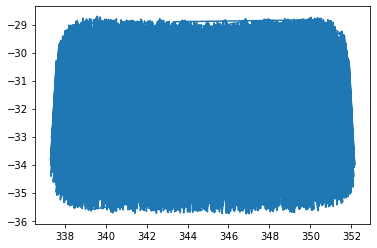

In [9]:
plt.plot(EMU_data['RA'], EMU_data['DEC'])

### <span style='background :LightPink' > GAMA

In [10]:
GFit=fits.open('GaussFitSimplev05.fits')
gkv=fits.open('gkvScienceCatv02.fits')
SMasses=fits.open('StellarMassesGKVv24.fits')

In [11]:
# GFit.info()
# gkv.info()
# SMasses.info()

In [12]:
GFit_data=Table(GFit[1].data)
#GFit_data

In [13]:
gkv_data=Table(gkv[1].data)
#gkv_data

In [14]:
SMasses_data=Table(SMasses[1].data)
#SMasses_data

In [15]:
SMasses_pd=SMasses_data.to_pandas()
gkv_pd=gkv_data.to_pandas()
GFit_pd=GFit_data.to_pandas()
EMU_pd=EMU_data.to_pandas()

#SMasses_pd

In [16]:
#SMasses_pd.loc[:,"uberID"]

In [17]:
GFit_pd=GFit_pd[GFit_pd.HA_FLUX >0]
#GFit_pd

In [18]:
GFit_pd=GFit_pd[GFit_pd.HB_FLUX >0]
#GFit_pd

## <span style='background :LightPink' > Cross Matching

### <span style='background :LightPink' > Join GAMA tables

##### <span style='background :LightPink' > gkv + SMasses

In [19]:
gkv_smasses = pd.merge(SMasses_pd, gkv_pd, on="uberID") 
#gkv_smasses

In [20]:
pd.set_option('display.max_columns', gkv_smasses.shape[0]+1)

##### <span style='background :LightPink' > gkv_smasses + GFit

In [21]:
# range=5/3600
# merged_data=[]
# for index1, row1 in gkv_smasses.iterrows():
#     for index2, row2 in GFit_pd.iterrows():
#         if np.absolute(row1['RAcen'] - row2['RA']) <= range:
#             merged_data.append({**row1, **row2})
# merged_df_loop = pd.DataFrame(merged_data)


In [22]:
# range=5/3600
# no=0
# merged_data=[]
# for index1, row1 in EMU_pd.iterrows():
#     for index2, row2 in gkv_smasses.iterrows():
#         dRA=np.absolute(row1['RA'] - row2['RAcen'])*np.cos(row1['DEC'])
#         ddec=np.absolute(row1['DEC'] - row2['Deccen'])
#         sep=np.sqrt((dRA**2)+(ddec**2))
#         if sep <= range:
#             merged_data.append({**row1, **row2})
#             no=no+1
#             print('sucess', no)
# merged_df_loop = pd.DataFrame(merged_data)


In [23]:
merged_df_loop

NameError: name 'merged_df_loop' is not defined

### <span style='background :LightPink' > Join GAMA and EMU tables 

In [24]:
EMU_GAMA=fits.open('G:\Project_AHopkins\Data\EMU_GAMA_DUST_20240927', ignore_missing_simple=True)
EMU_GAMA=Table(EMU_GAMA[1].data)
EMU_GAMA_pd=EMU_GAMA.to_pandas()
EMU_GAMA_pd

uberID_1       RAcen     Deccen       RAmax     Decmax  \
0     337660015307322  339.086079 -33.992006  339.086200 -33.991969   
1     337660028110052  339.069638 -33.734939  339.069633 -33.734997   
2     337660063707461  339.031074 -33.979172  339.031139 -33.979174   
3     337660064109616  339.029201 -33.776226  339.029178 -33.776263   
4     337660067503966  339.029336 -34.308037  339.029268 -34.308288   
...               ...         ...        ...         ...        ...   
5719  350701003108055  350.382758 -30.024162  350.382800 -30.024193   
5720  350701026307521  350.357272 -30.074469  350.357343 -30.074394   
5721  350701028002930  350.353571 -30.506697  350.353535 -30.506690   
5722  350701040104571  350.340938 -30.352201  350.341034 -30.352125   
5723  350701057705467  350.322207 -30.267719  350.322240 -30.267686   

          RAGAIA    DecGAIA      sky_mean   skyRMS_mean  log10seeing  \
0     339.086232 -33.992007 -2.350093e-13  3.636241e-12    -0.229771   
1     339.069664 -33.735034  1.087712e-13  3.561583e-12    -0.229771   
2     339.031170 -33.979211  1.175222e-13  3.746317e-12    -0.229771   
3     339.029209 -33.776300 -1.543749e-12  4.281982e-12    -0.229771   
4     339.029299 -34.308325 -3.846790e-13  3.952537e-12    -0.229771   
...          ...        ...           ...           ...          ...   
5719  350.382831 -30.024230 -5.009163e-13  3.821218e-12    -0.184533   
5720  350.357375 -30.074431 -1.064117e-13  4.214858e-12    -0.184533   
5721  350.353567 -30.506728 -3.367662e-12  4.571152e-12    -0.184533   
5722  350.341065 -30.352162 -3.784270e-13  4.242341e-12    -0.184533   
5723  350.322271 -30.267723  3.726400e-14  4.151760e-12    -0.184533   

           EBV        mag       R50       R90      R100  N100     axrat  \
0     0.014946  18.567139  1.242885  3.268996  6.227019   856  0.807538   
1     0.016688  19.755093  1.544850  3.321887  4.930385   424  0.638049   
2     0.015549  18.943775  1.261492  2.547143  4.381387   455  0.867037   
3     0.017568  19.286037  1.231142  2.348990  3.661646   359  0.979470   
4     0.016967  18.960306  1.625110  3.447919  6.267112   694  0.646359   
...        ...        ...       ...       ...       ...   ...       ...   
5719  0.021152  18.295872  1.957109  3.845410  7.457874  1229  0.808298   
5720  0.021010  19.035271  2.036448  4.328177  6.976392   991  0.744837   
5721  0.022809  17.290634  1.945878  3.830613  5.868216   742  0.788209   
5722  0.020136  17.373068  2.537210  5.671832  9.959446  1781  0.656815   
5723  0.021692  17.569193  2.045493  4.613569  9.987735  1955  0.716906   

             ang  flux_FUVt     flux_FUVl  flux_err_FUVt  flux_NUVt  \
0      16.557217   0.000020  1.960684e-05   1.984927e-09   0.000031   
1       2.264309   0.000001  7.493364e-07   1.622751e-09   0.000002   
2      56.371056   0.000010  8.199672e-06   1.818496e-09   0.000026   
3      31.530134   0.000009  5.292647e-06   2.536418e-09   0.000016   
4      15.102391   0.000009  8.742371e-06   8.107635e-09   0.000013   
...          ...        ...           ...            ...        ...   
5719   95.940254   0.000011  7.681289e-06   1.325708e-09   0.000028   
5720   47.973175   0.000011  9.052474e-06   3.821023e-09   0.000016   
5721  173.460846   0.000052  5.272275e-05   1.555730e-08   0.000058   
5722   73.157112   0.000016  1.582656e-05   1.049040e-08   0.000033   
5723  146.781998   0.000019  1.904640e-05   5.357110e-09   0.000020   

      flux_NUVl  flux_err_NUVt   flux_ut   flux_ul   flux_err_ut   flux_gt  \
0      0.000029   1.150653e-07  0.000047  0.000048  9.322336e-07  0.000095   
1      0.000002   7.646636e-08  0.000002  0.000002  6.710208e-07  0.000011   
2      0.000026   1.460101e-07  0.000033  0.000031  6.204929e-07  0.000059   
3      0.000016   1.623618e-07  0.000018  0.000017  5.393584e-07  0.000036   
4      0.000012   1.279767e-07  0.000025  0.000026  7.941910e-07  0.000055   
...         ...            ...       ...       ...           ...       ..

## <span style='background :LightPink' > Data Reduction

In [25]:
EMU_GAMA_pd=EMU_GAMA_pd[EMU_GAMA_pd.HA_FLUX >0]
EMU_GAMA_pd=EMU_GAMA_pd[EMU_GAMA_pd.HB_FLUX >0]
EMU_GAMA_pd

uberID_1       RAcen     Deccen       RAmax     Decmax  \
0     337660015307322  339.086079 -33.992006  339.086200 -33.991969   
2     337660063707461  339.031074 -33.979172  339.031139 -33.979174   
3     337660064109616  339.029201 -33.776226  339.029178 -33.776263   
4     337660067503966  339.029336 -34.308037  339.029268 -34.308288   
5     337660076210220  339.015019 -33.719434  339.015060 -33.719460   
...               ...         ...        ...         ...        ...   
5719  350701003108055  350.382758 -30.024162  350.382800 -30.024193   
5720  350701026307521  350.357272 -30.074469  350.357343 -30.074394   
5721  350701028002930  350.353571 -30.506697  350.353535 -30.506690   
5722  350701040104571  350.340938 -30.352201  350.341034 -30.352125   
5723  350701057705467  350.322207 -30.267719  350.322240 -30.267686   

          RAGAIA    DecGAIA      sky_mean   skyRMS_mean  log10seeing  \
0     339.086232 -33.992007 -2.350093e-13  3.636241e-12    -0.229771   
2     339.031170 -33.979211  1.175222e-13  3.746317e-12    -0.229771   
3     339.029209 -33.776300 -1.543749e-12  4.281982e-12    -0.229771   
4     339.029299 -34.308325 -3.846790e-13  3.952537e-12    -0.229771   
5     339.015091 -33.719498 -1.141675e-12  3.398414e-12    -0.229771   
...          ...        ...           ...           ...          ...   
5719  350.382831 -30.024230 -5.009163e-13  3.821218e-12    -0.184533   
5720  350.357375 -30.074431 -1.064117e-13  4.214858e-12    -0.184533   
5721  350.353567 -30.506728 -3.367662e-12  4.571152e-12    -0.184533   
5722  350.341065 -30.352162 -3.784270e-13  4.242341e-12    -0.184533   
5723  350.322271 -30.267723  3.726400e-14  4.151760e-12    -0.184533   

           EBV        mag       R50       R90      R100  N100     axrat  \
0     0.014946  18.567139  1.242885  3.268996  6.227019   856  0.807538   
2     0.015549  18.943775  1.261492  2.547143  4.381387   455  0.867037   
3     0.017568  19.286037  1.231142  2.348990  3.661646   359  0.979470   
4     0.016967  18.960306  1.625110  3.447919  6.267112   694  0.646359   
5     0.017692  18.755760  1.610277  4.165053  7.794178   955  0.575059   
...        ...        ...       ...       ...       ...   ...       ...   
5719  0.021152  18.295872  1.957109  3.845410  7.457874  1229  0.808298   
5720  0.021010  19.035271  2.036448  4.328177  6.976392   991  0.744837   
5721  0.022809  17.290634  1.945878  3.830613  5.868216   742  0.788209   
5722  0.020136  17.373068  2.537210  5.671832  9.959446  1781  0.656815   
5723  0.021692  17.569193  2.045493  4.613569  9.987735  1955  0.716906   

             ang  flux_FUVt     flux_FUVl  flux_err_FUVt  flux_NUVt  \
0      16.557217   0.000020  1.960684e-05   1.984927e-09   0.000031   
2      56.371056   0.000010  8.199672e-06   1.818496e-09   0.000026   
3      31.530134   0.000009  5.292647e-06   2.536418e-09   0.000016   
4      15.102391   0.000009  8.742371e-06   8.107635e-09   0.000013   
5     163.348648   0.000004  4.087041e-07   4.219054e-09   0.000005   
...          ...        ...           ...            ...        ...   
5719   95.940254   0.000011  7.681289e-06   1.325708e-09   0.000028   
5720   47.973175   0.000011  9.052474e-06   3.821023e-09   0.000016   
5721  173.460846   0.000052  5.272275e-05   1.555730e-08   0.000058   
5722   73.157112   0.000016  1.582656e-05   1.049040e-08   0.000033   
5723  146.781998   0.000019  1.904640e-05   5.357110e-09   0.000020   

      flux_NUVl  flux_err_NUVt   flux_ut   flux_ul   flux_err_ut   flux_gt  \
0      0.000029   1.150653e-07  0.000047  0.000048  9.322336e-07  0.000095   
2      0.000026   1.460101e-07  0.000033  0.000031  6.204929e-07  0.000059   
3      0.000016   1.623618e-07  0.000018  0.000017  5.393584e-07  0.000036   
4      0.000012   1.279767e-07  0.000025  0.000026  7.941910e-07  0.000055   
5      0.000005   1.391620e-07  0.000007  0.000010  8.972317e-07  0.000044   
...         ...            ...       ...       ...           ...       ..

In [26]:
#Signal to noise
EMU_GAMA_pd=EMU_GAMA_pd[(EMU_GAMA_pd.HA_FLUX/EMU_GAMA_pd.HA_FLUX_ERR) >3]
EMU_GAMA_pd=EMU_GAMA_pd[(EMU_GAMA_pd.HB_FLUX/EMU_GAMA_pd.HB_FLUX_ERR) >3]
EMU_GAMA_pd

uberID_1       RAcen     Deccen       RAmax     Decmax  \
0     337660015307322  339.086079 -33.992006  339.086200 -33.991969   
2     337660063707461  339.031074 -33.979172  339.031139 -33.979174   
3     337660064109616  339.029201 -33.776226  339.029178 -33.776263   
4     337660067503966  339.029336 -34.308037  339.029268 -34.308288   
7     337670023806226  339.269591 -33.095264  339.269564 -33.095291   
...               ...         ...        ...         ...        ...   
5719  350701003108055  350.382758 -30.024162  350.382800 -30.024193   
5720  350701026307521  350.357272 -30.074469  350.357343 -30.074394   
5721  350701028002930  350.353571 -30.506697  350.353535 -30.506690   
5722  350701040104571  350.340938 -30.352201  350.341034 -30.352125   
5723  350701057705467  350.322207 -30.267719  350.322240 -30.267686   

          RAGAIA    DecGAIA      sky_mean   skyRMS_mean  log10seeing  \
0     339.086232 -33.992007 -2.350093e-13  3.636241e-12    -0.229771   
2     339.031170 -33.979211  1.175222e-13  3.746317e-12    -0.229771   
3     339.029209 -33.776300 -1.543749e-12  4.281982e-12    -0.229771   
4     339.029299 -34.308325 -3.846790e-13  3.952537e-12    -0.229771   
7     339.269596 -33.095328 -3.663479e-13  4.891117e-12    -0.242635   
...          ...        ...           ...           ...          ...   
5719  350.382831 -30.024230 -5.009163e-13  3.821218e-12    -0.184533   
5720  350.357375 -30.074431 -1.064117e-13  4.214858e-12    -0.184533   
5721  350.353567 -30.506728 -3.367662e-12  4.571152e-12    -0.184533   
5722  350.341065 -30.352162 -3.784270e-13  4.242341e-12    -0.184533   
5723  350.322271 -30.267723  3.726400e-14  4.151760e-12    -0.184533   

           EBV        mag       R50       R90      R100  N100     axrat  \
0     0.014946  18.567139  1.242885  3.268996  6.227019   856  0.807538   
2     0.015549  18.943775  1.261492  2.547143  4.381387   455  0.867037   
3     0.017568  19.286037  1.231142  2.348990  3.661646   359  0.979470   
4     0.016967  18.960306  1.625110  3.447919  6.267112   694  0.646359   
7     0.016304  17.040258  1.389167  4.357172  9.548815  2474  0.992545   
...        ...        ...       ...       ...       ...   ...       ...   
5719  0.021152  18.295872  1.957109  3.845410  7.457874  1229  0.808298   
5720  0.021010  19.035271  2.036448  4.328177  6.976392   991  0.744837   
5721  0.022809  17.290634  1.945878  3.830613  5.868216   742  0.788209   
5722  0.020136  17.373068  2.537210  5.671832  9.959446  1781  0.656815   
5723  0.021692  17.569193  2.045493  4.613569  9.987735  1955  0.716906   

             ang     flux_FUVt     flux_FUVl  flux_err_FUVt  flux_NUVt  \
0      16.557217  1.976713e-05  1.960684e-05   1.984927e-09   0.000031   
2      56.371056  1.007130e-05  8.199672e-06   1.818496e-09   0.000026   
3      31.530134  9.416483e-06  5.292647e-06   2.536418e-09   0.000016   
4      15.102391  8.788473e-06  8.742371e-06   8.107635e-09   0.000013   
7      26.338959  1.000000e+20  1.000000e+20   0.000000e+00   0.000095   
...          ...           ...           ...            ...        ...   
5719   95.940254  1.106335e-05  7.681289e-06   1.325708e-09   0.000028   
5720   47.973175  1.135890e-05  9.052474e-06   3.821023e-09   0.000016   
5721  173.460846  5.246319e-05  5.272275e-05   1.555730e-08   0.000058   
5722   73.157112  1.581328e-05  1.582656e-05   1.049040e-08   0.000033   
5723  146.781998  1.908213e-05  1.904640e-05   5.357110e-09   0.000020   

      flux_NUVl  flux_err_NUVt   flux_ut   flux_ul   flux_err_ut   flux_gt  \
0      0.000029   1.150653e-07  0.000047  0.000048  9.322336e-07  0.000095   
2      0.000026   1.460101e-07  0.000033  0.000031  6.204929e-07  0.000059   
3      0.000016   1.623618e-07  0.000018  0.000017  5.393584e-07  0.000036   
4      0.000012   1.279767e-07  0.000025  0.000026  7.941910e-07  0.000055   
7      0.000093   2.255754e-07  0.000184  0.000173  1.505763e-06  0.000341   
...         ...            ...       

In [27]:
EMU_GAMA_pd=EMU_GAMA_pd[EMU_GAMA_pd['NQ_1']>=3]
EMU_GAMA_pd

uberID_1       RAcen     Deccen       RAmax     Decmax  \
0     337660015307322  339.086079 -33.992006  339.086200 -33.991969   
2     337660063707461  339.031074 -33.979172  339.031139 -33.979174   
3     337660064109616  339.029201 -33.776226  339.029178 -33.776263   
4     337660067503966  339.029336 -34.308037  339.029268 -34.308288   
7     337670023806226  339.269591 -33.095264  339.269564 -33.095291   
...               ...         ...        ...         ...        ...   
5719  350701003108055  350.382758 -30.024162  350.382800 -30.024193   
5720  350701026307521  350.357272 -30.074469  350.357343 -30.074394   
5721  350701028002930  350.353571 -30.506697  350.353535 -30.506690   
5722  350701040104571  350.340938 -30.352201  350.341034 -30.352125   
5723  350701057705467  350.322207 -30.267719  350.322240 -30.267686   

          RAGAIA    DecGAIA      sky_mean   skyRMS_mean  log10seeing  \
0     339.086232 -33.992007 -2.350093e-13  3.636241e-12    -0.229771   
2     339.031170 -33.979211  1.175222e-13  3.746317e-12    -0.229771   
3     339.029209 -33.776300 -1.543749e-12  4.281982e-12    -0.229771   
4     339.029299 -34.308325 -3.846790e-13  3.952537e-12    -0.229771   
7     339.269596 -33.095328 -3.663479e-13  4.891117e-12    -0.242635   
...          ...        ...           ...           ...          ...   
5719  350.382831 -30.024230 -5.009163e-13  3.821218e-12    -0.184533   
5720  350.357375 -30.074431 -1.064117e-13  4.214858e-12    -0.184533   
5721  350.353567 -30.506728 -3.367662e-12  4.571152e-12    -0.184533   
5722  350.341065 -30.352162 -3.784270e-13  4.242341e-12    -0.184533   
5723  350.322271 -30.267723  3.726400e-14  4.151760e-12    -0.184533   

           EBV        mag       R50       R90      R100  N100     axrat  \
0     0.014946  18.567139  1.242885  3.268996  6.227019   856  0.807538   
2     0.015549  18.943775  1.261492  2.547143  4.381387   455  0.867037   
3     0.017568  19.286037  1.231142  2.348990  3.661646   359  0.979470   
4     0.016967  18.960306  1.625110  3.447919  6.267112   694  0.646359   
7     0.016304  17.040258  1.389167  4.357172  9.548815  2474  0.992545   
...        ...        ...       ...       ...       ...   ...       ...   
5719  0.021152  18.295872  1.957109  3.845410  7.457874  1229  0.808298   
5720  0.021010  19.035271  2.036448  4.328177  6.976392   991  0.744837   
5721  0.022809  17.290634  1.945878  3.830613  5.868216   742  0.788209   
5722  0.020136  17.373068  2.537210  5.671832  9.959446  1781  0.656815   
5723  0.021692  17.569193  2.045493  4.613569  9.987735  1955  0.716906   

             ang     flux_FUVt     flux_FUVl  flux_err_FUVt  flux_NUVt  \
0      16.557217  1.976713e-05  1.960684e-05   1.984927e-09   0.000031   
2      56.371056  1.007130e-05  8.199672e-06   1.818496e-09   0.000026   
3      31.530134  9.416483e-06  5.292647e-06   2.536418e-09   0.000016   
4      15.102391  8.788473e-06  8.742371e-06   8.107635e-09   0.000013   
7      26.338959  1.000000e+20  1.000000e+20   0.000000e+00   0.000095   
...          ...           ...           ...            ...        ...   
5719   95.940254  1.106335e-05  7.681289e-06   1.325708e-09   0.000028   
5720   47.973175  1.135890e-05  9.052474e-06   3.821023e-09   0.000016   
5721  173.460846  5.246319e-05  5.272275e-05   1.555730e-08   0.000058   
5722   73.157112  1.581328e-05  1.582656e-05   1.049040e-08   0.000033   
5723  146.781998  1.908213e-05  1.904640e-05   5.357110e-09   0.000020   

      flux_NUVl  flux_err_NUVt   flux_ut   flux_ul   flux_err_ut   flux_gt  \
0      0.000029   1.150653e-07  0.000047  0.000048  9.322336e-07  0.000095   
2      0.000026   1.460101e-07  0.000033  0.000031  6.204929e-07  0.000059   
3      0.000016   1.623618e-07  0.000018  0.000017  5.393584e-07  0.000036   
4      0.000012   1.279767e-07  0.000025  0.000026  7.941910e-07  0.000055   
7      0.000093   2.255754e-07  0.000184  0.000173  1.505763e-06  0.000341   
...         ...            ...       

In [28]:
EMU_GAMA_pd=EMU_GAMA_pd[EMU_GAMA_pd['HA_EW']>0]
EMU_GAMA_pd=EMU_GAMA_pd[EMU_GAMA_pd['HB_EW']>0]
EMU_GAMA_pd

uberID_1       RAcen     Deccen       RAmax     Decmax  \
0     337660015307322  339.086079 -33.992006  339.086200 -33.991969   
2     337660063707461  339.031074 -33.979172  339.031139 -33.979174   
3     337660064109616  339.029201 -33.776226  339.029178 -33.776263   
4     337660067503966  339.029336 -34.308037  339.029268 -34.308288   
7     337670023806226  339.269591 -33.095264  339.269564 -33.095291   
...               ...         ...        ...         ...        ...   
5719  350701003108055  350.382758 -30.024162  350.382800 -30.024193   
5720  350701026307521  350.357272 -30.074469  350.357343 -30.074394   
5721  350701028002930  350.353571 -30.506697  350.353535 -30.506690   
5722  350701040104571  350.340938 -30.352201  350.341034 -30.352125   
5723  350701057705467  350.322207 -30.267719  350.322240 -30.267686   

          RAGAIA    DecGAIA      sky_mean   skyRMS_mean  log10seeing  \
0     339.086232 -33.992007 -2.350093e-13  3.636241e-12    -0.229771   
2     339.031170 -33.979211  1.175222e-13  3.746317e-12    -0.229771   
3     339.029209 -33.776300 -1.543749e-12  4.281982e-12    -0.229771   
4     339.029299 -34.308325 -3.846790e-13  3.952537e-12    -0.229771   
7     339.269596 -33.095328 -3.663479e-13  4.891117e-12    -0.242635   
...          ...        ...           ...           ...          ...   
5719  350.382831 -30.024230 -5.009163e-13  3.821218e-12    -0.184533   
5720  350.357375 -30.074431 -1.064117e-13  4.214858e-12    -0.184533   
5721  350.353567 -30.506728 -3.367662e-12  4.571152e-12    -0.184533   
5722  350.341065 -30.352162 -3.784270e-13  4.242341e-12    -0.184533   
5723  350.322271 -30.267723  3.726400e-14  4.151760e-12    -0.184533   

           EBV        mag       R50       R90      R100  N100     axrat  \
0     0.014946  18.567139  1.242885  3.268996  6.227019   856  0.807538   
2     0.015549  18.943775  1.261492  2.547143  4.381387   455  0.867037   
3     0.017568  19.286037  1.231142  2.348990  3.661646   359  0.979470   
4     0.016967  18.960306  1.625110  3.447919  6.267112   694  0.646359   
7     0.016304  17.040258  1.389167  4.357172  9.548815  2474  0.992545   
...        ...        ...       ...       ...       ...   ...       ...   
5719  0.021152  18.295872  1.957109  3.845410  7.457874  1229  0.808298   
5720  0.021010  19.035271  2.036448  4.328177  6.976392   991  0.744837   
5721  0.022809  17.290634  1.945878  3.830613  5.868216   742  0.788209   
5722  0.020136  17.373068  2.537210  5.671832  9.959446  1781  0.656815   
5723  0.021692  17.569193  2.045493  4.613569  9.987735  1955  0.716906   

             ang     flux_FUVt     flux_FUVl  flux_err_FUVt  flux_NUVt  \
0      16.557217  1.976713e-05  1.960684e-05   1.984927e-09   0.000031   
2      56.371056  1.007130e-05  8.199672e-06   1.818496e-09   0.000026   
3      31.530134  9.416483e-06  5.292647e-06   2.536418e-09   0.000016   
4      15.102391  8.788473e-06  8.742371e-06   8.107635e-09   0.000013   
7      26.338959  1.000000e+20  1.000000e+20   0.000000e+00   0.000095   
...          ...           ...           ...            ...        ...   
5719   95.940254  1.106335e-05  7.681289e-06   1.325708e-09   0.000028   
5720   47.973175  1.135890e-05  9.052474e-06   3.821023e-09   0.000016   
5721  173.460846  5.246319e-05  5.272275e-05   1.555730e-08   0.000058   
5722   73.157112  1.581328e-05  1.582656e-05   1.049040e-08   0.000033   
5723  146.781998  1.908213e-05  1.904640e-05   5.357110e-09   0.000020   

      flux_NUVl  flux_err_NUVt   flux_ut   flux_ul   flux_err_ut   flux_gt  \
0      0.000029   1.150653e-07  0.000047  0.000048  9.322336e-07  0.000095   
2      0.000026   1.460101e-07  0.000033  0.000031  6.204929e-07  0.000059   
3      0.000016   1.623618e-07  0.000018  0.000017  5.393584e-07  0.000036   
4      0.000012   1.279767e-07  0.000025  0.000026  7.941910e-07  0.000055   
7      0.000093   2.255754e-07  0.000184  0.000173  1.505763e-06  0.000341   
...         ...            ...       

In [29]:
EMU_GAMA_pd=EMU_GAMA_pd[EMU_GAMA_pd['HA_FLUX']<100000]
EMU_GAMA_pd=EMU_GAMA_pd[EMU_GAMA_pd['HB_FLUX']<100000]
EMU_GAMA_pd

uberID_1       RAcen     Deccen       RAmax     Decmax  \
0     337660015307322  339.086079 -33.992006  339.086200 -33.991969   
2     337660063707461  339.031074 -33.979172  339.031139 -33.979174   
3     337660064109616  339.029201 -33.776226  339.029178 -33.776263   
4     337660067503966  339.029336 -34.308037  339.029268 -34.308288   
7     337670023806226  339.269591 -33.095264  339.269564 -33.095291   
...               ...         ...        ...         ...        ...   
5719  350701003108055  350.382758 -30.024162  350.382800 -30.024193   
5720  350701026307521  350.357272 -30.074469  350.357343 -30.074394   
5721  350701028002930  350.353571 -30.506697  350.353535 -30.506690   
5722  350701040104571  350.340938 -30.352201  350.341034 -30.352125   
5723  350701057705467  350.322207 -30.267719  350.322240 -30.267686   

          RAGAIA    DecGAIA      sky_mean   skyRMS_mean  log10seeing  \
0     339.086232 -33.992007 -2.350093e-13  3.636241e-12    -0.229771   
2     339.031170 -33.979211  1.175222e-13  3.746317e-12    -0.229771   
3     339.029209 -33.776300 -1.543749e-12  4.281982e-12    -0.229771   
4     339.029299 -34.308325 -3.846790e-13  3.952537e-12    -0.229771   
7     339.269596 -33.095328 -3.663479e-13  4.891117e-12    -0.242635   
...          ...        ...           ...           ...          ...   
5719  350.382831 -30.024230 -5.009163e-13  3.821218e-12    -0.184533   
5720  350.357375 -30.074431 -1.064117e-13  4.214858e-12    -0.184533   
5721  350.353567 -30.506728 -3.367662e-12  4.571152e-12    -0.184533   
5722  350.341065 -30.352162 -3.784270e-13  4.242341e-12    -0.184533   
5723  350.322271 -30.267723  3.726400e-14  4.151760e-12    -0.184533   

           EBV        mag       R50       R90      R100  N100     axrat  \
0     0.014946  18.567139  1.242885  3.268996  6.227019   856  0.807538   
2     0.015549  18.943775  1.261492  2.547143  4.381387   455  0.867037   
3     0.017568  19.286037  1.231142  2.348990  3.661646   359  0.979470   
4     0.016967  18.960306  1.625110  3.447919  6.267112   694  0.646359   
7     0.016304  17.040258  1.389167  4.357172  9.548815  2474  0.992545   
...        ...        ...       ...       ...       ...   ...       ...   
5719  0.021152  18.295872  1.957109  3.845410  7.457874  1229  0.808298   
5720  0.021010  19.035271  2.036448  4.328177  6.976392   991  0.744837   
5721  0.022809  17.290634  1.945878  3.830613  5.868216   742  0.788209   
5722  0.020136  17.373068  2.537210  5.671832  9.959446  1781  0.656815   
5723  0.021692  17.569193  2.045493  4.613569  9.987735  1955  0.716906   

             ang     flux_FUVt     flux_FUVl  flux_err_FUVt  flux_NUVt  \
0      16.557217  1.976713e-05  1.960684e-05   1.984927e-09   0.000031   
2      56.371056  1.007130e-05  8.199672e-06   1.818496e-09   0.000026   
3      31.530134  9.416483e-06  5.292647e-06   2.536418e-09   0.000016   
4      15.102391  8.788473e-06  8.742371e-06   8.107635e-09   0.000013   
7      26.338959  1.000000e+20  1.000000e+20   0.000000e+00   0.000095   
...          ...           ...           ...            ...        ...   
5719   95.940254  1.106335e-05  7.681289e-06   1.325708e-09   0.000028   
5720   47.973175  1.135890e-05  9.052474e-06   3.821023e-09   0.000016   
5721  173.460846  5.246319e-05  5.272275e-05   1.555730e-08   0.000058   
5722   73.157112  1.581328e-05  1.582656e-05   1.049040e-08   0.000033   
5723  146.781998  1.908213e-05  1.904640e-05   5.357110e-09   0.000020   

      flux_NUVl  flux_err_NUVt   flux_ut   flux_ul   flux_err_ut   flux_gt  \
0      0.000029   1.150653e-07  0.000047  0.000048  9.322336e-07  0.000095   
2      0.000026   1.460101e-07  0.000033  0.000031  6.204929e-07  0.000059   
3      0.000016   1.623618e-07  0.000018  0.000017  5.393584e-07  0.000036   
4      0.000012   1.279767e-07  0.000025  0.000026  7.941910e-07  0.000055   
7      0.000093   2.255754e-07  0.000184  0.000173  1.505763e-06  0.000341   
...         ...            ...       

In [30]:
#EMU_GAMA=Table.from_pandas(EMU_GAMA_pd)
#EMU_GAMA.write('EMU_GAMA_reduced_20240927.fits')

## <span style='background :LightPink' > BPT Diagnostics

add kewley and kauffmann lines 

kauffmann log(OIII/HB) = 1.3 + 0.61/(log(NII/HA)-0.05)

kewely log(OIII/HB) = (0.61/(log(NII/HA) -0.47))+ 1.19 

In [31]:
HB=EMU_GAMA_pd['HB_FLUX']
HA=EMU_GAMA_pd['HA_FLUX']
NII=EMU_GAMA_pd['NIIR_FLUX']
OIII=EMU_GAMA_pd['OIIIR_FLUX']

x=np.log10(NII/HA)
y=np.log10(OIII/HB)

D:\anaconda\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [32]:
x=np.array(x)
x[:]

array([-0.768742  , -0.6477185 , -0.53502727, ..., -0.30639756,
       -0.40140283, -0.44538495], dtype=float32)

In [33]:
EMU_GAMA_pd.insert(2, "log(NII/Ha)", x[:])
EMU_GAMA_pd.insert(3, "log(OIII/HB)", y[:])

Text(0, 0.5, 'log([OIII] $\\lambda$ 5007/H$\\beta$)')

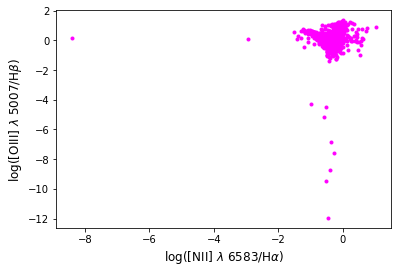

In [34]:
Nsize = 12
fig, ax = plt.subplots()
plt.scatter(EMU_GAMA_pd['log(NII/Ha)'],EMU_GAMA_pd['log(OIII/HB)'], marker=".", color='magenta')
ax.set_xlabel(r'log([NII] $\lambda$ 6583/H$\alpha$)',fontsize=Nsize)
ax.set_ylabel(r'log([OIII] $\lambda$ 5007/H$\beta$)',fontsize=Nsize)

In [35]:
x1=np.log10(np.arange(-50, 1, 0.01))
x2=np.log10(np.arange(-50, 2.5, 0.01))
y1=1.3 + 0.61/(x1-0.05) #kauffmann
y2=(0.61/(x2 -0.47))+1.19  #kewely

C:\Users\Jayde\AppData\Local\Temp\ipykernel_9128\3782894524.py:1: RuntimeWarning: invalid value encountered in log10
  x1=np.log10(np.arange(-50, 1, 0.01))
C:\Users\Jayde\AppData\Local\Temp\ipykernel_9128\3782894524.py:2: RuntimeWarning: invalid value encountered in log10
  x2=np.log10(np.arange(-50, 2.5, 0.01))


Text(0, 0.5, 'log([OIII] $\\lambda$ 5007/H$\\beta$)')

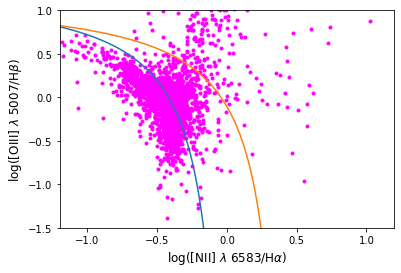

In [36]:

fig, ax = plt.subplots()
plt.scatter(EMU_GAMA_pd['log(NII/Ha)'],EMU_GAMA_pd['log(OIII/HB)'], marker=".", color='magenta')
plt.plot(x1,y1)
plt.plot(x2, y2)
ax.set_xlim(-1.2,1.2)
ax.set_ylim(-1.5,1)
ax.set_xlabel(r'log([NII] $\lambda$ 6583/H$\alpha$)',fontsize=Nsize)
ax.set_ylabel(r'log([OIII] $\lambda$ 5007/H$\beta$)',fontsize=Nsize)

In [37]:

H, xedges, yedges = np.histogram2d(EMU_GAMA_pd['log(NII/Ha)'],EMU_GAMA_pd['log(OIII/HB)'],range=[[-1.3,1.3],[-1.5,1.1]], bins=60)
xmesh, ymesh = np.meshgrid(xedges[:-1], yedges[:-1])
if astro_smooth:
    kernel = Gaussian2DKernel(x_stddev=1)
    H=convolve(H,kernel)


Text(0, 0.5, 'log([OIII] $\\lambda$ 5007/H$\\beta$)')

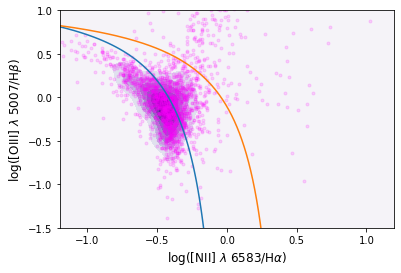

In [38]:
fig, ax = plt.subplots()
clevels = ax.contourf(xmesh,ymesh,H.T, cmap='Purples')
plt.scatter(EMU_GAMA_pd['log(NII/Ha)'],EMU_GAMA_pd['log(OIII/HB)'], marker=".", color='magenta', alpha=0.15)
plt.plot(x1,y1, label='Kaufmann')
plt.plot(x2, y2)
ax.set_xlim(-1.2,1.2)
ax.set_ylim(-1.5,1)
ax.set_xlabel(r'log([NII] $\lambda$ 6583/H$\alpha$)',fontsize=Nsize)
ax.set_ylabel(r'log([OIII] $\lambda$ 5007/H$\beta$)',fontsize=Nsize)

## 

### <span style='background :LightPink' > Creating Sample1

In [39]:
sample1=EMU_GAMA_pd[EMU_GAMA_pd['log(OIII/HB)']<1.3 + 0.61/(EMU_GAMA_pd['log(NII/Ha)']-0.05)]
#sample1

In [40]:
sample1=sample1[sample1['log(NII/Ha)']<0]

In [41]:
#sample1
#plt.scatter(sample1['log(NII/Ha)'], sample1['log(OIII/HB)'])

In [42]:
sample1['log(NII/Ha)']

0      -0.768742
2      -0.647718
3      -0.535027
4      -0.667588
10     -0.598294
          ...   
5714   -0.429037
5719   -0.727045
5720   -0.712849
5722   -0.401403
5723   -0.445385
Name: log(NII/Ha), Length: 1163, dtype: float32

In [43]:
#from astropy.table import Table
t=Table.from_pandas(sample1)
#t.write('G:\\Project_AHopkins\Data\sample1_27092024.csv')

### <span style='background :LightPink' > Creating Sample2

In [44]:
sample2=EMU_GAMA_pd[EMU_GAMA_pd['log(OIII/HB)']>1.3 + 0.61/(EMU_GAMA_pd['log(NII/Ha)']-0.05)]

In [154]:
#(0.61/(x -0.47))+1.19
sample2=sample2[sample2['log(OIII/HB)']<1.19 + 0.61/(sample2['log(NII/Ha)']-0.47)]
#sample2

In [46]:
samp2=Table.from_pandas(sample2)
#samp2.write('G:\\Project_AHopkins\Data\sample2_27092024.csv', overwrite=True)

### <span style='background :LightPink' > Creating Sample3

In [47]:
mask1= (EMU_GAMA_pd['log(OIII/HB)']>1.19 + 0.61/(EMU_GAMA_pd['log(NII/Ha)']-0.47))
mask2= (EMU_GAMA_pd['log(NII/Ha)']>0.1)


In [155]:
sample3=EMU_GAMA_pd[mask1 | mask2]
#sample3

uberID_1       RAcen  log(NII/Ha)  log(OIII/HB)     Deccen  \
7     337670023806226  339.269591     0.382285      0.256419 -33.095264   
22    337670171507380  339.102895    -0.011263      0.922536 -32.987410   
41    338650579309269  339.346089     0.727105      0.627844 -34.810579   
47    338660023507627  340.276593     0.162174      0.288015 -33.963211   
116   338660531912098  339.698991    -0.309577      0.446928 -33.544049   
...               ...         ...          ...           ...        ...   
5642  350690764206009  350.540667     0.008999      1.345141 -31.217432   
5651  350690841804690  350.454943    -0.153690      0.853743 -31.341506   
5659  350690899704717  350.391076    -0.204808      0.863814 -31.338783   
5697  350700578103242  350.845235     0.065510      0.037378 -30.478098   
5700  350700714905249  350.695975     0.032172      0.164914 -30.289005   

           RAmax     Decmax      RAGAIA    DecGAIA      sky_mean  ...  \
7     339.269564 -33.095291  339.269596 -33.095328 -3.663479e-13  ...   
22    339.102938 -32.987405  339.102970 -32.987442 -1.928169e-13  ...   
41    339.346105 -34.810525  339.346137 -34.810563 -6.235388e-14  ...   
47    340.276659 -33.963302  340.276690 -33.963339 -3.079692e-14  ...   
116   339.698968 -33.544112  339.699000 -33.544149 -4.644351e-13  ...   
...          ...        ...         ...        ...           ...  ...   
5642  350.540671 -31.217417  350.540703 -31.217454 -1.420212e-13  ...   
5651  350.454905 -31.341488  350.454937 -31.341525 -3.908604e-13  ...   
5659  350.391078 -31.338808  350.391109 -31.338845 -2.902626e-13  ...   
5697  350.845235 -30.478064  350.845266 -30.478101 -6.711830e-13  ...   
5700  350.695963 -30.289040  350.695995 -30.289078 -2.533868e-13  ...   

       Zgas_16   Zgas_84  DustMass_bestfit   DustMass_50   DustMass_16  \
7    -1.440220 -1.300000      2.208563e+08  2.139447e+08  1.492411e+08   
22   -1.475809 -1.300000      6.054465e+08  5.337824e+08  3.775798e+08   
41   -1.675927 -1.414483      4.677385e+07  2.784665e+07  9.463161e+06   
47   -1.346798 -1.300000      2.082784e+08  2.311703e+08  1.844912e+08   
116  -1.731188 -1.442246      3.211717e+08  4.048167e+08  3.282369e+08   
...        ...       ...               ...           ...           ...   
5642 -1.581592 -1.300000      2.337264e+08  2.325708e+08  1.659448e+08   
5651 -1.362086 -1.300000      1.359982e+08  1.842398e+08  1.367934e+08   
5659 -1.460506 -1.300000      1.885846e+08  1.673761e+08  1.190665e+08   
5697 -1.365282 -1.300000      1.478589e+08  9.893042e+07  6.680796e+07   
5700 -1.898732 -1.300000      5.320658e+07  1.734357e+08  4.220364e+07   

       DustMass_84    DustLum_50    DustLum_16    DustLum_84           uberID  
7     2.867751e+08  6.652339e+10  5.484237e+10  9.673501e+10  339671091406233  
22    6.922639e+08  1.085695e+11  9.194424e+10  1.213145e+11  337670171507380  
41    5.826653e+07  4.065042e+10  3.398914e+10  4.944591e+10  338650579309269  
47    2.927649e+08  6.166429e+10  5.325575e+10  7.049675e+10  338660023507627  
116   4.802763e+08  7.861039e+10  7.063737e+10  8.679654e+10  339670708901478  
...            ...           ...           ...           ...              ...  
5642  2.792061e+08  3.190098e+10  2.546609e+10  3.875854e+10  350690764206009  
5651  2.339198e+08  2.590197e+10  2.312437e+10  2.868635e+10  350690841804690  
5659  2.103112e+08  3.331573e+10  2.464199e+10  4.117292e+10  350690899704717  
5697  1.692251e+08  1.247833e+11  1.107264e+11  1.384544e+11  350700578103242  
5700  3.004535e+08  6.076179e+10  3.149417e+10  1.273855e+11  350700714905249  

[203 rows x 449 columns]

In [49]:
samp3=Table.from_pandas(sample3)
#samp3.write('G:\\Project_AHopkins\Data\sample3_27092024.csv', overwrite=True)

### <span style='background :LightPink' > Return to BPT

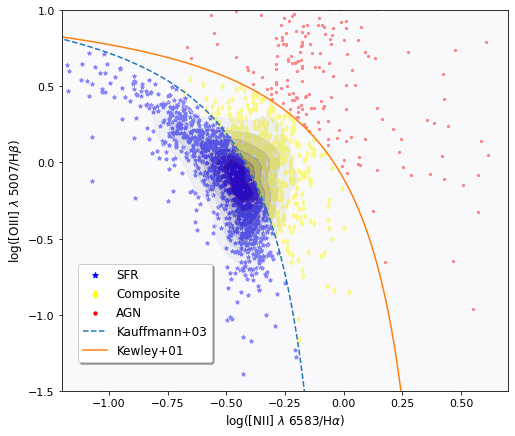

In [50]:
fig, ax = plt.subplots(figsize=(8,7))

plt.scatter(sample1['log(NII/Ha)'], sample1['log(OIII/HB)'], color='blue', marker='*', sizes=[15], label='SFR')
plt.scatter(sample2['log(NII/Ha)'], sample2['log(OIII/HB)'], color='yellow',marker='d', sizes=[15], label='Composite')
plt.scatter(sample3['log(NII/Ha)'], sample3['log(OIII/HB)'], color='red', marker='.',sizes=[20], label='AGN')


#plt.scatter(EMU_GAMA_pd['log(NII/Ha)'],EMU_GAMA_pd['log(OIII/HB)'], marker=".", color='black')
clevels = ax.contourf(xmesh,ymesh,H.T, cmap='Purples',alpha=0.55)

plt.plot(x1,y1, linestyle='dashed', label='Kauffmann+03')
plt.plot(x2, y2, label='Kewley+01' )
ax.set_xlim(-1.2,0.7)
ax.set_ylim(-1.5,1)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
ax.legend(loc='upper right', bbox_to_anchor=(0.35, 0.35), fontsize=12, markerscale=1.5, shadow=True)
ax.set_xlabel(r'log([NII] $\lambda$ 6583/H$\alpha$)',fontsize=12)
ax.set_ylabel(r'log([OIII] $\lambda$ 5007/H$\beta$)',fontsize=12)
#plt.scatter(kaufmann_points[0],kaufmann_points[1], marker="*", alpha=0.3)
plt.savefig('E:\\BPT.png')

## <span style='background :LightPink' > Radio Flux to SFR

## <span style='background :LightPink' >  Calculate Distances

In [51]:
z_1=np.array(sample1['Z_1'])

In [52]:
print(cosmopy.api('z', z_1[0]))

{'z': '0.1656', 'a': '0.8579', 'dc': '689.5620 Mpc', 'dl': '803.7397 Mpc', 'da': '591.6042 Mpc', 'arc': '2868.1779 pc', 'tl': '2.0832 Gyr', 'ta': '11.6695 Gyr', 'dm': '39.5256'}


In [53]:
sample1['Z_1']

0       0.16558
2       0.27759
3       0.30732
4       0.20676
10      0.06811
         ...   
5714    0.08315
5719    0.20657
5720    0.13208
5722    0.13444
5723    0.06332
Name: Z_1, Length: 1163, dtype: float32

In [54]:
#COPIED TO ABOVE
sample1=sample1[sample1['HA_FLUX']<100000]
sample1=sample1[sample1['HA_EW']>0]

In [55]:
#pd.set_option('display.max_rows', None)
pd.reset_option('all')

D:\anaconda\lib\site-packages\pandas\_config\config.py:653: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  warnings.warn(d.msg, FutureWarning)
D:\anaconda\lib\site-packages\pandas\_config\config.py:653: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


In [56]:
sample1['HA_FLUX']

0       29468.783203
2         732.737061
3         424.253235
4         447.676147
10       3752.279053
            ...     
5714    32747.402344
5719    13437.446289
5720      210.414764
5722    22865.724609
5723    11847.493164
Name: HA_FLUX, Length: 1163, dtype: float32

In [57]:
#comoving method
DistLum=(1+sample1['Z_1'])*(sample1['comovingdist'])
DistLum

0        789.963989
2       1414.558228
3       1590.806519
4       1012.061890
10       302.367523
           ...     
5714     373.661804
5719    1010.623352
5720     615.844299
5722     627.897217
5723     279.604004
Length: 1163, dtype: float32

In [58]:
#Mpc to m
DistLum=DistLum*3.08567758128E+22
DistLum

0       2.437574e+25
2       4.364870e+25
3       4.908716e+25
4       3.122897e+25
10      9.330087e+24
            ...     
5714    1.153000e+25
5719    3.118458e+25
5720    1.900297e+25
5722    1.937488e+25
5723    8.627678e+24
Length: 1163, dtype: float32

In [59]:
sample1.insert(2, "Luminosity_Distance", DistLum[:])

In [60]:
from astropy.cosmology import WMAP9 as cosmo
cosmo.luminosity_distance(0.07594)

<Quantity 347.49888225 Mpc>

## <span style='background :LightPink' > Radio Luminosity


<div>
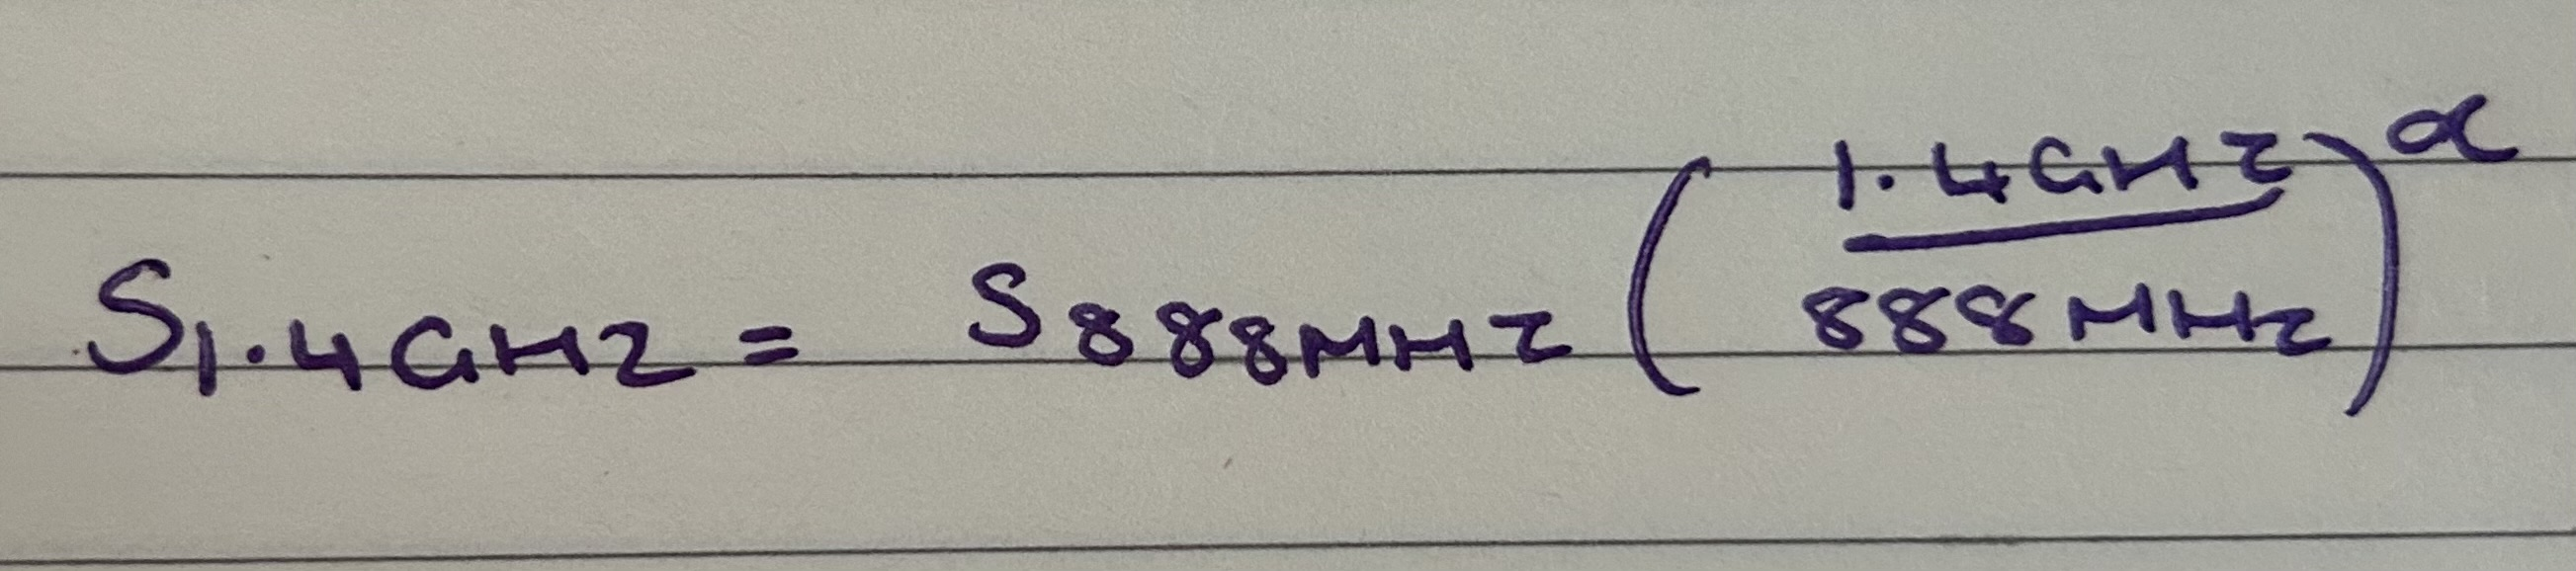
</div>



<div>
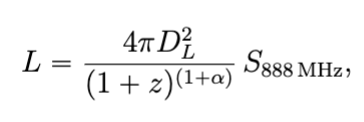
</div>

In [61]:
Dl=np.array(sample1['Luminosity_Distance'])


In [62]:
i=0
alpha=-0.7
flux888=np.array(sample1['Total_flux']*(10**(-26)))  #Janksy flux to W/Hz
flux14=np.array((sample1['Total_flux']*((1400/888)**alpha))*(10**(-26))) # 888 to 1.4 + Janksy flux to W/Hz
Dl2=[]
RadioLum14=[]
RadioLum888=[]
while i<1163:
 Dl2.append(float(Dl[i]**2))
 RadioLum888.append(((4*math.pi*Dl2[i])*flux888[i])/((1+z_1[i])**(1+alpha)))
 RadioLum14.append(((4*math.pi*Dl2[i])*flux14[i])/((1+z_1[i])**(1+alpha)))
 i=i+1

In [63]:
RadioLum14

[2.9666389547784572e+22,
 5.4659564038156565e+22,
 5.7894895756630836e+22,
 3.1144775815327453e+22,
 6.220904157315667e+21,
 3.2607342917206296e+22,
 2.230905494577421e+22,
 1.1270598479198196e+23,
 4.396409954768799e+21,
 1.4770470342831737e+22,
 1.1302638507622975e+22,
 1.0668167908097059e+23,
 1.0108165139738774e+22,
 2.0014413521359106e+22,
 6.722208344361993e+21,
 5.555201006934937e+22,
 4.530611241465061e+22,
 3.629923452441775e+22,
 1.4522375281128705e+22,
 2.4535715720711738e+22,
 6.005382111662996e+22,
 8.94111634036812e+21,
 1.803951844998355e+22,
 1.1240367291331957e+22,
 4.000696845214445e+22,
 1.474838660562637e+22,
 1.0614736952078763e+22,
 8.038468446985497e+22,
 7.221706303708737e+21,
 1.7598746571157356e+22,
 7.931448528102417e+22,
 4.830236179830501e+22,
 9.782066616349309e+21,
 7.173909932174379e+21,
 1.2243926788483613e+22,
 7.784769148640227e+21,
 9.513851126164444e+21,
 9.691708792895464e+22,
 3.415310350892452e+22,
 4.440196968008755e+21,
 2.790828008758933e+21,


In [64]:
sample1.insert(2, "Radio_luminosity_14", RadioLum14[:])
sample1.insert(3, "Radio_luminosity_888", RadioLum888[:])


In [65]:
sample1=sample1[sample1['Radio_luminosity_14']<9e24]

In [66]:
sample1

uberID_1       RAcen  Radio_luminosity_14  Radio_luminosity_888  \
0     337660015307322  339.086079         2.966639e+22          4.080048e+22   
2     337660063707461  339.031074         5.465956e+22          7.517384e+22   
3     337660064109616  339.029201         5.789490e+22          7.962342e+22   
4     337660067503966  339.029336         3.114478e+22          4.283372e+22   
10    337670054901341  339.238103         6.220904e+21          8.555671e+21   
...               ...         ...                  ...                   ...   
5714  350700902306866  350.492093         8.812480e+21          1.211989e+22   
5719  350701003108055  350.382758         2.195452e+22          3.019427e+22   
5720  350701026307521  350.357272         1.300144e+23          1.788101e+23   
5722  350701040104571  350.340938         2.181334e+22          3.000010e+22   
5723  350701057705467  350.322207         1.840073e+21          2.530671e+21   

      Luminosity_Distance  log(NII/Ha)  log(OIII/HB)     Deccen       RAmax  \
0            2.437574e+25    -0.768742      0.366008 -33.992006  339.086200   
2            4.364870e+25    -0.647718      0.168466 -33.979172  339.031139   
3            4.908716e+25    -0.535027      0.226008 -33.776226  339.029178   
4            3.122897e+25    -0.667588      0.173701 -34.308037  339.029268   
10           9.330087e+24    -0.598294      0.051552 -33.555198  339.237950   
...                   ...          ...           ...        ...         ...   
5714         1.153000e+25    -0.429037     -0.349897 -30.136401  350.492077   
5719         3.118458e+25    -0.727045     -0.185723 -30.024162  350.382800   
5720         1.900297e+25    -0.712849      0.124575 -30.074469  350.357343   
5722         1.937488e+25    -0.401403     -0.069131 -30.352201  350.341034   
5723         8.627678e+24    -0.445385     -0.148987 -30.267719  350.322240   

         Decmax  ...   Zgas_16   Zgas_84  DustMass_bestfit   DustMass_50  \
0    -33.991969  ... -1.750702 -1.471971      1.993058e+08  2.101867e+08   
2    -33.979174  ... -1.730675 -1.300000      1.216326e+08  1.366423e+08   
3    -33.776263  ... -1.961143 -1.437897      1.134774e+07  2.474820e+07   
4    -34.308288  ... -1.686146 -1.454063      3.096605e+08  2.949962e+08   
10   -33.555439  ... -2.024387 -1.769998      7.329348e+07  8.584997e+07   
...         ...  ...       ...       ...               ...           ...   
5714 -30.136455  ... -1.517454 -1.300000      6.286991e+07  3.864522e+07   
5719 -30.024193  ... -1.972705 -1.528802      3.100192e+08  2.870679e+08   
5720 -30.074394  ... -1.793917 -1.401841      5.518692e+06  7.674942e+05   
5722 -30.352125  ... -1.637408 -1.386055      2.241911e+08  2.136106e+08   
5723 -30.267686  ... -1.819582 -1.493973      5.315158e+07  5.117048e+07   

       DustMass_16   DustMass_84    DustLum_50    DustLum_16    DustLum_84  \
0     1.534745e+08  2.592441e+08  2.800991e+10  2.412348e+10  3.635747e+10   
2     7.033252e+07  2.299405e+08  7.406338e+10  6.151544e+10  9.070058e+10   
3     3.301156e+06  1.777813e+08  4.890049e+10  3.430423e+10  1.092692e+11   
4     2.230230e+08  3.734846e+08  6.675478e+10  6.104367e+10  7.402255e+10   
10    6.577192e+07  1.049765e+08  1.356369e+10  1.266812e+10  1.485027e+10   
...            ...           ...           ...           ...           ...   
5714  1.809681e+07  8.193255e+07  2.193433e+10  1.652379e+10  3.027521e+10   
5719  1.422809e+08  4.208902e+08  4.281858e+10  3.506062e+10  6.223780e+10   
5720  1.261835e+05  8.542194e+06  7.826745e+09  6.360885e+09  9.456894e+09   
5722  1.604303e+08  2.606047e+08  4.417676e+10  3.571403e+10  5.030358e+10   
5723  4.133876e+07  6.083873e+07  6.677293e+09  6.004131e+09  7.386367e+09   

               uberID  
0     338661071907331  
2     338661120507464  
3     338661123409619  
4     338661120203968  
10    337670054901341  
...               ...  
5714  350700902306866  
5719  350701003108055  
5720  350701026307521  
5722  3507010

## <span style='background :LightPink' >  Radio Lum to SFR

## <span style='background :LightPink' > Bell 2003


<div>
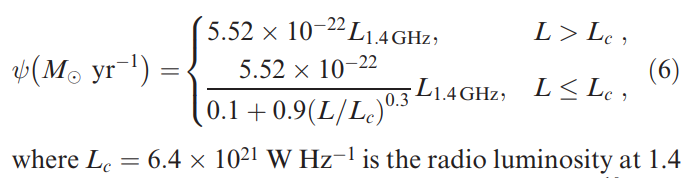
</div>

Is L our L_1.4?

Below is the version from A Hopkins 2003 10.1086/379608

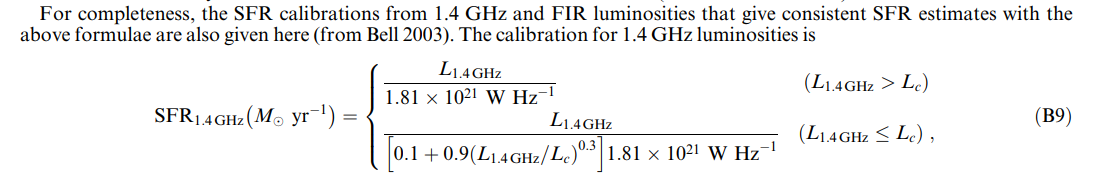


In [67]:
# i=0
# Bell_SFR=[]
# while i<1248:
#     if RadioLum14[i]>(6.4e21):
#         Bell_SFR.append((5.5e-22)*RadioLum14[i])
#     else: 
#         Bell_SFR.append(((5.5e-22)*RadioLum14[i])/(0.1+0.9*((RadioLum14[i]/6.4e21)**0.3)))
#     i=i+1

In [68]:
# i=0
# Bell_SFR=[]
# while i<1248:
#     if RadioLum14[i]>(6.4e21):
#         Bell_SFR.append((1/(1.81e21))*RadioLum14[i])
#     else: 
#         Bell_SFR.append((RadioLum14[i])/(1.81e21*(0.1+0.9*((RadioLum14[i]/(6.4e21))**0.3))))
#     i=i+1

In [69]:
i=0
Bell_SFR=[]
for x in sample1['Radio_luminosity_14']:
    if x>(6.4e21):
        Bell_SFR.append((1/(1.81e21))*x)
    else: 
        Bell_SFR.append((x)/(1.81e21*(0.1+0.9*((x/(6.4e21))**0.3))))
    i=i+1

In [70]:
RadioLum14

[2.9666389547784572e+22,
 5.4659564038156565e+22,
 5.7894895756630836e+22,
 3.1144775815327453e+22,
 6.220904157315667e+21,
 3.2607342917206296e+22,
 2.230905494577421e+22,
 1.1270598479198196e+23,
 4.396409954768799e+21,
 1.4770470342831737e+22,
 1.1302638507622975e+22,
 1.0668167908097059e+23,
 1.0108165139738774e+22,
 2.0014413521359106e+22,
 6.722208344361993e+21,
 5.555201006934937e+22,
 4.530611241465061e+22,
 3.629923452441775e+22,
 1.4522375281128705e+22,
 2.4535715720711738e+22,
 6.005382111662996e+22,
 8.94111634036812e+21,
 1.803951844998355e+22,
 1.1240367291331957e+22,
 4.000696845214445e+22,
 1.474838660562637e+22,
 1.0614736952078763e+22,
 8.038468446985497e+22,
 7.221706303708737e+21,
 1.7598746571157356e+22,
 7.931448528102417e+22,
 4.830236179830501e+22,
 9.782066616349309e+21,
 7.173909932174379e+21,
 1.2243926788483613e+22,
 7.784769148640227e+21,
 9.513851126164444e+21,
 9.691708792895464e+22,
 3.415310350892452e+22,
 4.440196968008755e+21,
 2.790828008758933e+21,


In [71]:
sample1.insert(2, "Bell_SFR", Bell_SFR[:])

## <span style='background :LightPink' > Condon 1992

$$ SFR(M\ge 5M_☉) = \frac{5.3\times 10^{-21}  L_{1.4GHz}}{(1.4)^{0.7}} $$


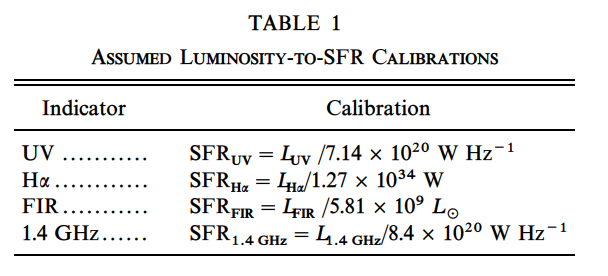


In [72]:
#below A 2001 condon with calibration
Condon_SFR=(sample1['Radio_luminosity_14']/(8.4e20))

In [73]:
sample1.insert(2, "Condon_SFR", Condon_SFR[:])
Condon_SFR

0        35.317130
2        65.070910
3        68.922495
4        37.077114
10        7.405838
           ...    
5714     10.491048
5719     26.136334
5720    154.779026
5722     25.968261
5723      2.190563
Name: Radio_luminosity_14, Length: 1162, dtype: float64

## <span style='background :LightPink' > Hα Flux to SFR

### <span style='background :LightPink' > Calculate L$_{H\alpha}$

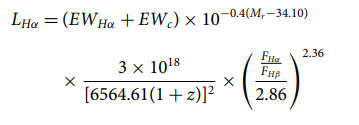


In [74]:
Ha=sample1['HA_FLUX']
Hb=sample1['HB_FLUX']

In [75]:
EW_Ha=sample1['HA_EW']
EW_HB=sample1['HB_EW']
EW_c= 2.5  #˚A from Hopkins(2003)  #EWc is the equivalent width correction for stellar absorption #Tania uses 2.5 from AHopkins 2013
Mr=sample1['absmag_r']
z=sample1['Z_1']

In [76]:
SHa=(EW_Ha+EW_c)*(Ha/EW_Ha)
SHB=(EW_HB+EW_c)*(Hb/EW_HB)
BD=SHa/SHB

In [77]:
Lum_HA=(EW_Ha + EW_c)*(10**(-0.4*(Mr-34.10)))*((3e18)/(6564.61*(1+z))**2)*((BD/2.86)**2.36)

In [78]:
Lum_HA=np.array(Lum_HA)
Lum_HA

array([2.0512460e+35, 2.7142693e+35, 3.4188580e+35, ..., 1.1627570e+34,
       1.3947707e+35, 1.1535415e+34], dtype=float32)

In [79]:
sample1.insert(2, "HA_Luminosity", Lum_HA[:])

## <span style='background :LightPink' > Ahmed 2024 - Really Kennicut 1998

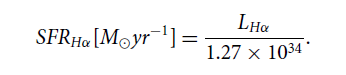
From Tanias^^ THIS IS REALLY KENNICUT 1998

In [80]:
SFR_HA_Tan=1.27e-34*Lum_HA
SFR_HA_Tan

array([26.050823 , 34.47122  , 43.419495 , ...,  1.4767013, 17.713587 ,
        1.4649976], dtype=float32)

In [81]:
sample1.insert(2, "Ha_SFR", SFR_HA_Tan[:])

## <span style='background :LightPink' > Radio + Ha to SFR 

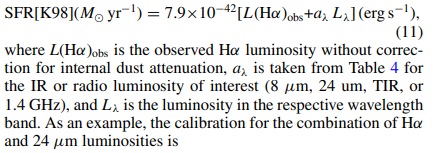

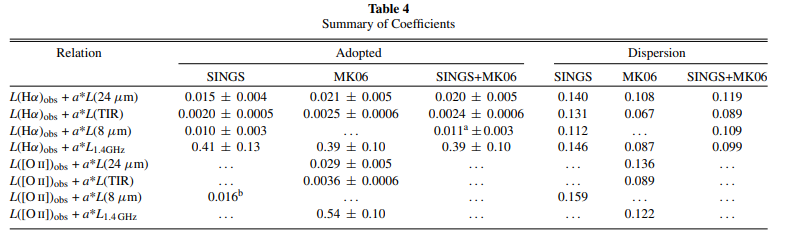

From 2009 paper

In [82]:
# K09_SFR=((7.9e-42)*((Lum_HA*(1e7))+(0.39*sample1['Radio_luminosity_14']*(1e7))))

In [83]:
K09_SFR=(7.9e-35)*((Lum_HA)+(0.39*sample1['Radio_luminosity_14']))

In [84]:
K09_SFR

0       16.204844
2       21.442727
3       27.008978
4       19.479270
10      10.139031
          ...    
5714    13.495464
5719    10.604770
5720     0.918578
5722    11.018689
5723     0.911298
Name: Radio_luminosity_14, Length: 1162, dtype: float64

In [85]:
sample1.insert(2, "K09_SFR", K09_SFR[:])


## <span style='background :LightPink' > Ha + Dust Mass SFR (Tanias) </span>

In [86]:
Dust_Mass=sample1['DustMass_bestfit']
Dust_Mass

0       1.993058e+08
2       1.216326e+08
3       1.134774e+07
4       3.096605e+08
10      7.329348e+07
            ...     
5714    6.286991e+07
5719    3.100192e+08
5720    5.518692e+06
5722    2.241911e+08
5723    5.315158e+07
Name: DustMass_bestfit, Length: 1162, dtype: float64

### <span style='background :LightPink' > Calculate $\tau$

$\tau^l_B = 2.303\log(\frac{\text{H}\alpha}{\text{H}\beta}) - 1.0508$

In [87]:
tau=2.303*np.log10(Ha/Hb)-1.0508
tau

0       0.873497
2       0.620333
3       1.193045
4       1.497259
10      0.920247
          ...   
5714    1.838001
5719    0.899251
5720    0.563942
5722    0.926170
5723    0.772039
Length: 1162, dtype: float32

### <span style='background :LightPink' > Calculate H$_{dust}$

$H_{\rm dust} = \frac{M_d}{10^{\tau^l_B}}$

In [88]:
H_dust=Dust_Mass/(10**tau)
H_dust

0       2.666999e+07
2       2.915527e+07
3       7.275519e+05
4       9.854323e+06
10      8.806805e+06
            ...     
5714    9.129394e+05
5719    3.909647e+07
5720    1.506241e+06
5722    2.657349e+07
5723    8.984145e+06
Length: 1162, dtype: float64

### <span style='background :LightPink' > Calculate L$_{H\alpha,improved}$

In [89]:
L_Ha_impr=(10**((np.log10(H_dust)-22.564)/(1.165)))*(Lum_HA)
L_Ha_impr

0       2.079916e+22
2       2.970948e+22
3       1.575011e+21
4       1.063698e+22
10      5.027436e+21
            ...     
5714    9.562679e+20
5719    1.890123e+22
5720    1.000374e+20
5722    1.409872e+22
5723    4.596661e+20
Length: 1162, dtype: float64

In [90]:
np.log10(L_Ha_impr/Lum_HA)

0      -12.993972
2      -12.960758
3      -14.336597
4      -13.365127
10     -13.407023
          ...    
5714   -14.251981
5719   -12.851384
5720   -14.065327
5722   -12.995323
5723   -13.399591
Length: 1162, dtype: float64

### <span style='background :LightPink' > Calculate SFR

In [91]:
#This is the incorrect Method
# Dust_SFR=(7.9e-35)*(Lum_HA+(0.39e13*L_Ha_impr))
# Dust_SFR

In [92]:
#This is apparently correct
# Dust_SFR=L_Ha_impr*(1.27e-34)
# Dust_SFR

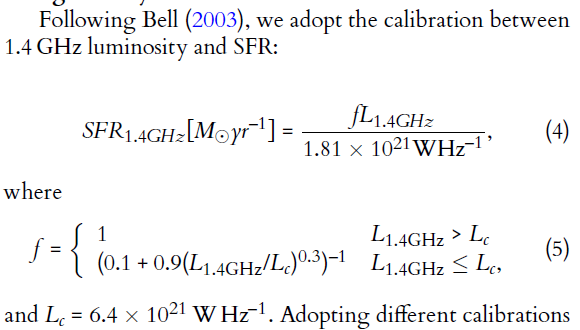

In [93]:
i=0
Dust_SFR=[]
for x in L_Ha_impr:
    if x>(6.4e21):
        Dust_SFR.append((1/(1.81e21))*x)
    else: 
        Dust_SFR.append((x)/(1.81e21*(0.1+0.9*((x/(6.4e21))**0.3))))
    i=i+1

In [94]:
Dust_SFR

[11.491251052665518,
 16.414079223726567,
 1.2593280125588953,
 5.8767848384982555,
 2.9639338111098295,
 7.745841757021866,
 7.082874164550711,
 29.01532066571449,
 0.7173781637481095,
 11.296301559808452,
 2.082191692859156,
 31.833117836010672,
 1.3672281916335403,
 2.4922725420673104,
 1.96597181109028,
 17.726564958339292,
 22.453053054318207,
 23.686137741021046,
 3.0057388982570283,
 1.0115261821538868,
 60.52877890454723,
 2.461367819525427,
 7.267776392683359,
 2.017130818799849,
 10.507541993323418,
 3.428454679243421,
 2.5848534230021047,
 36.04397624617557,
 0.5150697290329441,
 10.98154124634076,
 74.75085303152186,
 18.80924498860817,
 5.190196108334167,
 0.22877434685352976,
 4.092969348594242,
 2.08547298533529,
 1.8218299035153163,
 36.512490849760596,
 22.187262456889925,
 2.4013567405312504,
 0.5415643325636559,
 4.189295732882679,
 4.205491674807248,
 0.6513815591250383,
 21.302312104199988,
 10.235264607519996,
 2.406652904300968,
 22.38982104471011,
 8.76225179914

In [95]:
sample1.insert(2, "Dust_SFR", Dust_SFR[:])

### <span style='background :LightPink' >Final Cuts

In [96]:
sample1=sample1[sample1['HA_Luminosity']>2e-13]
sample1

uberID_1       RAcen   Dust_SFR    K09_SFR     Ha_SFR  \
0     337660015307322  339.086079  11.491251  16.204844  26.050823   
2     337660063707461  339.031074  16.414079  21.442727  34.471218   
3     337660064109616  339.029201   1.259328  27.008978  43.419495   
4     337660067503966  339.029336   5.876785  19.479270  31.314775   
10    337670054901341  339.238103   2.963934  10.139031  16.299454   
...               ...         ...        ...        ...        ...   
5714  350700902306866  350.492093   0.867788  13.495464  21.695238   
5719  350701003108055  350.382758  10.442669  10.604770  17.048174   
5720  350701026307521  350.357272   0.154174   0.918578   1.476701   
5722  350701040104571  350.340938   7.789348  11.018689  17.713587   
5723  350701057705467  350.322207   0.499493   0.911298   1.464998   

      HA_Luminosity  Condon_SFR   Bell_SFR  Radio_luminosity_14  \
0      2.051246e+35   35.317130  16.390270         2.966639e+22   
2      2.714269e+35   65.070910  30.198654         5.465956e+22   
3      3.418858e+35   68.922495  31.986130         5.789490e+22   
4      2.465730e+35   37.077114  17.207058         3.114478e+22   
10     1.283422e+35    7.405838   3.463392         6.220904e+21   
...             ...         ...        ...                  ...   
5714   1.708287e+35   10.491048   4.868773         8.812480e+21   
5719   1.342376e+35   26.136334  12.129569         2.195452e+22   
5720   1.162757e+34  154.779026  71.831150         1.300144e+23   
5722   1.394771e+35   25.968261  12.051569         2.181334e+22   
5723   1.153541e+34    2.190563   1.413513         1.840073e+21   

      Radio_luminosity_888  ...   Zgas_16   Zgas_84  DustMass_bestfit  \
0             4.080048e+22  ... -1.750702 -1.471971      1.993058e+08   
2             7.517384e+22  ... -1.730675 -1.300000      1.216326e+08   
3             7.962342e+22  ... -1.961143 -1.437897      1.134774e+07   
4             4.283372e+22  ... -1.686146 -1.454063      3.096605e+08   
10            8.555671e+21  ... -2.024387 -1.769998      7.329348e+07   
...                    ...  ...       ...       ...               ...   
5714          1.211989e+22  ... -1.517454 -1.300000      6.286991e+07   
5719          3.019427e+22  ... -1.972705 -1.528802      3.100192e+08   
5720          1.788101e+23  ... -1.793917 -1.401841      5.518692e+06   
5722          3.000010e+22  ... -1.637408 -1.386055      2.241911e+08   
5723          2.530671e+21  ... -1.819582 -1.493973      5.315158e+07   

       DustMass_50   DustMass_16   DustMass_84    DustLum_50    DustLum_16  \
0     2.101867e+08  1.534745e+08  2.592441e+08  2.800991e+10  2.412348e+10   
2     1.366423e+08  7.033252e+07  2.299405e+08  7.406338e+10  6.151544e+10   
3     2.474820e+07  3.301156e+06  1.777813e+08  4.890049e+10  3.430423e+10   
4     2.949962e+08  2.230230e+08  3.734846e+08  6.675478e+10  6.104367e+10   
10    8.584997e+07  6.577192e+07  1.049765e+08  1.356369e+10  1.266812e+10   
...            ...           ...           ...           ...           ...   
5714  3.864522e+07  1.809681e+07  8.193255e+07  2.193433e+10  1.652379e+10   
5719  2.870679e+08  1.422809e+08  4.208902e+08  4.281858e+10  3.506062e+10   
5720  7.674942e+05  1.261835e+05  8.542194e+06  7.826745e+09  6.360885e+09   
5722  2.136106e+08  1.604303e+08  2.606047e+08  4.417676e+10  3.571403e+10   
5723  5.117048e+07  4.133876e+07  6.083873e+07  6.677293e+09  6.004131e+09   

        DustLum_84           uberID  
0     3.635747e+10  338661071907331  
2     9.070058e+10  338661120507464  
3     1.092692e+11  338661123409619  
4     7.402255e+10  338661120203968  
10    1.485027e+10  337670054901341  
...            ...              ...  
5714  3.027521e+10  350700902306866  
5719  6.223780e+10  350701003108055  
5720  9.456894e+09  350701026307521  
5722  5.030358e+10  350701040104571  
5723  7.386367e+09  350701057705467  

[1161 rows x 458 columns]

In [97]:
t=Table.from_pandas(sample1)
t.write('G:\\Project_AHopkins\Data\sample1_final.fits', overwrite=True)

## <span style='background :LightPink' >  Import Prospect Data

In [98]:
Prospect_Data=fits.open('G:\Project_AHopkins\Data\EMU_GAMA_DUST_SED_20241008', ignore_missing_simple=True)
Prospect_Data=Table(Prospect_Data[1].data)
Prospect_Data_pd=Prospect_Data.to_pandas()
#Prospect_Data_pd

In [99]:
#Sort each set of SED params based on whether they used radio or not. 
#The data is such that an radio then non radio pair will appear one after another so we can sort by indices.
Prospect_Radio=Prospect_Data_pd.iloc[::2]
Prospect_Radio_SFR=Prospect_Radio['SFRpeak']
Prospect_Radio_SFR=Prospect_Radio_SFR.values.astype(float)

Prospect_NoRadio=Prospect_Data_pd.iloc[1::2]
Prospect_NoRadio_SFR=Prospect_NoRadio['SFRpeak']
Prospect_NoRadio_SFR=Prospect_NoRadio_SFR.values.astype(float)
len(Prospect_NoRadio_SFR)

1161

## <span style='background :LightPink' > Corner Plot

Goal:
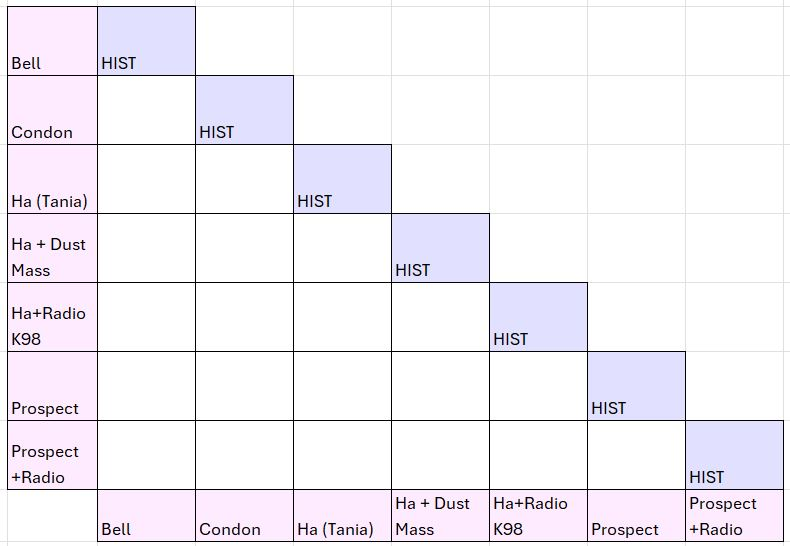

In [100]:
SFR_all= sample1[['Bell_SFR', 'Condon_SFR', 'Ha_SFR', 'K09_SFR', 'Dust_SFR']].copy()

In [101]:
## ADD PROSPECT
SFR_all.insert(5, "Prospect_NoRadio_SFR", Prospect_NoRadio_SFR[:])
SFR_all.insert(6, "Prospect_Radio_SFR", Prospect_Radio_SFR[:])

In [102]:
SFR_all

Bell_SFR  Condon_SFR     Ha_SFR    K09_SFR   Dust_SFR  \
0     16.390270   35.317130  26.050823  16.204844  11.491251   
2     30.198654   65.070910  34.471218  21.442727  16.414079   
3     31.986130   68.922495  43.419495  27.008978   1.259328   
4     17.207058   37.077114  31.314775  19.479270   5.876785   
10     3.463392    7.405838  16.299454  10.139031   2.963934   
...         ...         ...        ...        ...        ...   
5714   4.868773   10.491048  21.695238  13.495464   0.867788   
5719  12.129569   26.136334  17.048174  10.604770  10.442669   
5720  71.831150  154.779026   1.476701   0.918578   0.154174   
5722  12.051569   25.968261  17.713587  11.018689   7.789348   
5723   1.413513    2.190563   1.464998   0.911298   0.499493   

      Prospect_NoRadio_SFR  Prospect_Radio_SFR  
0                 6.483469            6.150622  
2                35.771830           35.771830  
3                 6.327932            6.364971  
4                 4.299996            4.299996  
10                3.826066            5.003819  
...                    ...                 ...  
5714             14.327373           11.780931  
5719             18.985642           19.866944  
5720              1.440223            1.605249  
5722             10.497985           10.660763  
5723              1.654195            1.649750  

[1161 rows x 7 columns]

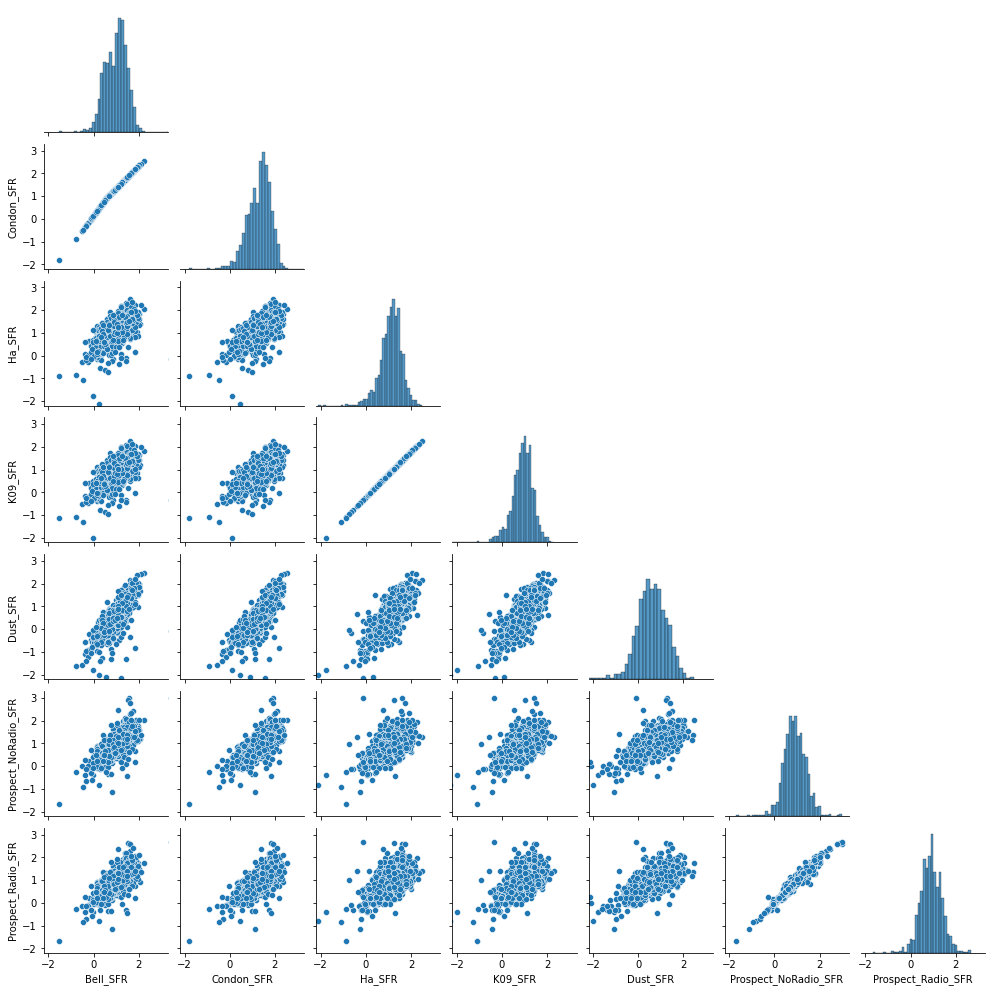

In [103]:
sns_plot=sns.pairplot(np.log10(SFR_all), corner=True, height=2)
sns_plot.set(xlim=(-2.2, 3.3), ylim=(-2.2,3.3))

#sns_plot.savefig('Corner.png')
#ns.set_theme(font_scale=12)

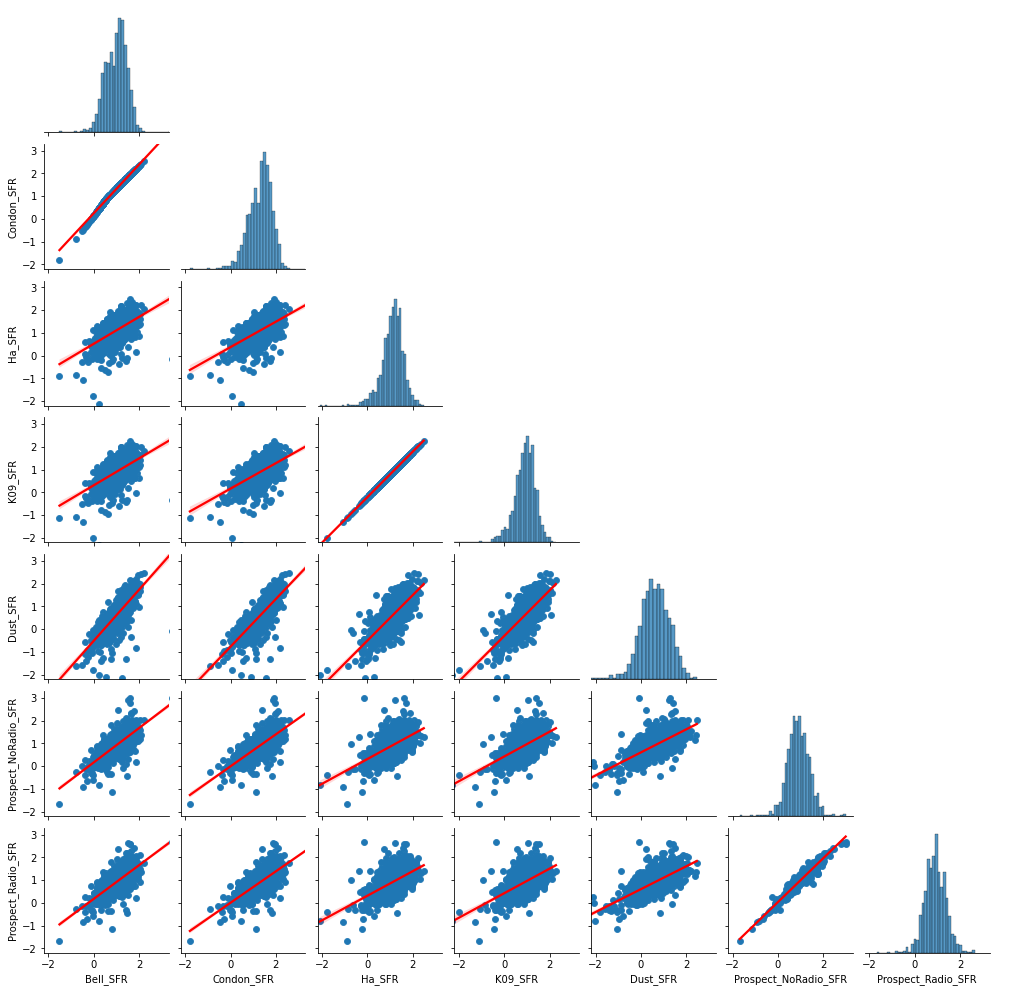

In [104]:
sns_plot=sns.pairplot(np.log10(SFR_all), corner=True, height=2)
sns_plot.map_lower(sns.regplot, line_kws=dict(color="r"))
sns_plot.add_legend()
sns_plot.set(xlim=(-2.2, 3.3), ylim=(-2.2,3.3))

In [105]:
def plot_unity(xdata, ydata, **kwargs):
    mn = min(-2.2, -2.2)
    mx = max(3.3, 3.3)
    points = np.linspace(mn, mx, 100)
    plt.gca().plot(points, points, color='k', marker=None,
            linestyle='-', linewidth=2.0, alpha=0.2)


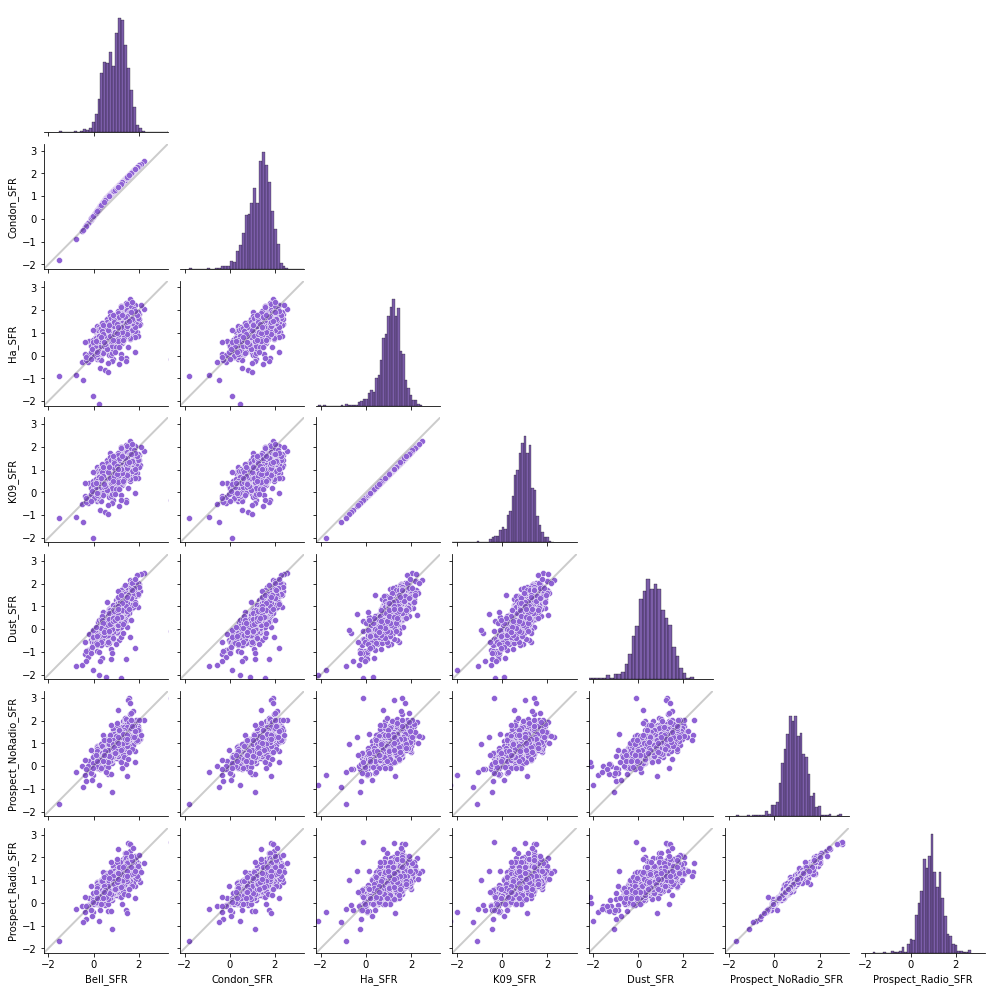

In [106]:

sns_plot=sns.pairplot(np.log10(SFR_all), corner=True, height=2, plot_kws={'color':'#8e61d4'}, diag_kws= {'color': '#50288d'})
sns_plot.set(xlim=(-2.2, 3.3), ylim=(-2.2,3.3))
sns_plot.map_lower(plot_unity)
#sns_plot.savefig('Corner.png')

In [107]:
#sns_plot.savefig('Cornerlines.png')

## <span style='background :LightPink' > LOBF Gradient and Stats

In [108]:
def best_fit_slope_and_intercept(xs,ys):
    m = (((mean(xs)*mean(ys)) - mean(xs*ys)) /
         ((mean(xs)*mean(xs)) - mean(xs*xs)))
    
    b = mean(ys) - m*mean(xs)
    
    return m, b


In [109]:
mbs=[]
mbs.append(['BellvsCondon',best_fit_slope_and_intercept(SFR_all['Bell_SFR'],SFR_all['Condon_SFR'])])
mbs.append(['BellvsHa',best_fit_slope_and_intercept(SFR_all['Bell_SFR'],SFR_all['Ha_SFR'])])
mbs.append(['BellvsK09',best_fit_slope_and_intercept(SFR_all['Bell_SFR'],SFR_all['K09_SFR'])])
mbs.append(['BellvsDust',best_fit_slope_and_intercept(SFR_all['Bell_SFR'],SFR_all['Dust_SFR'])])
mbs.append(['BellvsProspect_NoRadio',best_fit_slope_and_intercept(SFR_all['Bell_SFR'],SFR_all['Prospect_NoRadio_SFR'])])
mbs.append(['BellvsProspect_Radio',best_fit_slope_and_intercept(SFR_all['Bell_SFR'],SFR_all['Prospect_Radio_SFR'])])

mbs.append(['CondonvsHa',best_fit_slope_and_intercept(SFR_all['Condon_SFR'],SFR_all['Ha_SFR'])])
mbs.append(['CondonvsK09',best_fit_slope_and_intercept(SFR_all['Condon_SFR'],SFR_all['K09_SFR'])])
mbs.append(['CondonvsDust',best_fit_slope_and_intercept(SFR_all['Condon_SFR'],SFR_all['Dust_SFR'])])
mbs.append(['CondonvsProspect_NoRadio',best_fit_slope_and_intercept(SFR_all['Condon_SFR'],SFR_all['Prospect_NoRadio_SFR'])])
mbs.append(['CondonvsProspect_Radio',best_fit_slope_and_intercept(SFR_all['Condon_SFR'],SFR_all['Prospect_Radio_SFR'])])


mbs.append(['HavsK09',best_fit_slope_and_intercept(SFR_all['Ha_SFR'],SFR_all['K09_SFR'])])
mbs.append(['HavsDust',best_fit_slope_and_intercept(SFR_all['Ha_SFR'],SFR_all['Dust_SFR'])])
mbs.append(['HavsProspect_NoRadio',best_fit_slope_and_intercept(SFR_all['Ha_SFR'],SFR_all['Prospect_NoRadio_SFR'])])
mbs.append(['HavsProspect_Radio',best_fit_slope_and_intercept(SFR_all['Ha_SFR'],SFR_all['Prospect_Radio_SFR'])])

mbs.append(['K09vsDust',best_fit_slope_and_intercept(SFR_all['K09_SFR'],SFR_all['Dust_SFR'])])
mbs.append(['K09vsProspect_NoRadio',best_fit_slope_and_intercept(SFR_all['K09_SFR'],SFR_all['Prospect_NoRadio_SFR'])])
mbs.append(['K09vsProspect_Radio',best_fit_slope_and_intercept(SFR_all['K09_SFR'],SFR_all['Prospect_Radio_SFR'])])

mbs.append(['Prospect_NoRadiovsProspect_Radio',best_fit_slope_and_intercept(SFR_all['Prospect_NoRadio_SFR'],SFR_all['Prospect_Radio_SFR'])])


In [110]:
mbs

[['BellvsCondon', (2.1550605127523212, -0.12232179600137272)],
 ['BellvsHa', (0.0235454855974165, 20.986488346676055)],
 ['BellvsK09', (0.01464640483889857, 13.05458759962173)],
 ['BellvsDust', (0.03812609165443752, 10.206305642326884)],
 ['BellvsProspect_NoRadio', (0.3762433550042468, 10.183506013997308)],
 ['BellvsProspect_Radio', (0.18625756313692735, 12.037558429692353)],
 ['CondonvsHa', (0.010981683999530638, 20.98559296403917)],
 ['CondonvsK09', (0.006831126459631206, 13.054030629305396)],
 ['CondonvsDust', (0.017727733540214508, 10.207022943020808)],
 ['CondonvsProspect_NoRadio', (0.17461589163782038, 10.203669888865708)],
 ['CondonvsProspect_Radio', (0.08646366352444186, 12.046709281651813)],
 ['HavsK09', (0.6220472592355343, 4.3625620449461167e-08)],
 ['HavsDust', (0.48744486158567507, 0.47078857061379864)],
 ['HavsProspect_NoRadio', (0.2355320700414299, 12.11557237984836)],
 ['HavsProspect_Radio', (0.2209418018860561, 10.758667337599995)],
 ['K09vsDust', (0.7836138720435416, 

## <span style='background :LightPink' > Scatter


-Find distances to 1to1 line  

-Plot  

-fit Gaussian  

-find sd

In [111]:
def point_to_line_distance(x0, y0, slope, intercept):
    # Calculate the perpendicular distance
    distance = (slope * x0 - y0 + intercept) / np.sqrt(slope**2 + 1)
    return distance

In [112]:
# #distance to LOBF

dist_LOBF={'BellvsCondon': point_to_line_distance(SFR_all['Bell_SFR'],SFR_all['Condon_SFR'], mbs[0][1][0], mbs[0][1][1]),
        'BellvsHa': point_to_line_distance(SFR_all['Bell_SFR'],SFR_all['Ha_SFR'], mbs[1][1][0], mbs[1][1][1]),
        'BellvsK09': point_to_line_distance(SFR_all['Bell_SFR'],SFR_all['K09_SFR'], mbs[2][1][0], mbs[2][1][1]),
        'BellvsDust': point_to_line_distance(SFR_all['Bell_SFR'],SFR_all['Dust_SFR'], mbs[3][1][0], mbs[3][1][1]),
        'BellvsProspect_NoRadio': point_to_line_distance(SFR_all['Bell_SFR'],SFR_all['Prospect_NoRadio_SFR'], mbs[4][1][0], mbs[4][1][1]),
        'BellvsProspect_Radio': point_to_line_distance(SFR_all['Bell_SFR'],SFR_all['Prospect_Radio_SFR'], mbs[5][1][0], mbs[5][1][1]),
      
        'CondonvsHa': point_to_line_distance(SFR_all['Condon_SFR'],SFR_all['Ha_SFR'], mbs[6][1][0], mbs[6][1][1]),
        'CondonvsK09': point_to_line_distance(SFR_all['Condon_SFR'],SFR_all['K09_SFR'], mbs[7][1][0], mbs[7][1][1]),
        'CondonvsDust': point_to_line_distance(SFR_all['Condon_SFR'],SFR_all['Dust_SFR'], mbs[8][1][0], mbs[8][1][1]),
        'CondonvsProspect_NoRadio': point_to_line_distance(SFR_all['Condon_SFR'],SFR_all['Prospect_NoRadio_SFR'], mbs[9][1][0], mbs[9][1][1]),
        'CondonvsProspect_Radio': point_to_line_distance(SFR_all['Condon_SFR'],SFR_all['Prospect_Radio_SFR'], mbs[10][1][0], mbs[10][1][1]),
      
        'HavsK09':point_to_line_distance(SFR_all['Ha_SFR'],SFR_all['K09_SFR'], mbs[11][1][0], mbs[11][1][1]),
        'HavsDust': point_to_line_distance(SFR_all['Ha_SFR'],SFR_all['Dust_SFR'], mbs[12][1][0], mbs[12][1][1]),
        'HavsProspect_NoRadio': point_to_line_distance(SFR_all['Ha_SFR'],SFR_all['Prospect_NoRadio_SFR'], mbs[13][1][0], mbs[13][1][1]),
        'HavsProspect_Radio': point_to_line_distance(SFR_all['Ha_SFR'],SFR_all['Prospect_Radio_SFR'], mbs[14][1][0], mbs[14][1][1]),
      
        'K09vsDust': point_to_line_distance(SFR_all['K09_SFR'],SFR_all['Dust_SFR'], mbs[15][1][0], mbs[15][1][1]),
        'K09vsProspect_NoRadio': point_to_line_distance(SFR_all['K09_SFR'],SFR_all['Prospect_NoRadio_SFR'], mbs[16][1][0], mbs[16][1][1]),
        'K09vsProspect_Radio': point_to_line_distance(SFR_all['K09_SFR'],SFR_all['Prospect_Radio_SFR'], mbs[17][1][0], mbs[17][1][1]),
      
        'Prospect_NoRadiovsProspect_Radio': point_to_line_distance(SFR_all['Prospect_NoRadio_SFR'],SFR_all['Prospect_Radio_SFR'], mbs[18][1][0], mbs[18][1][1])
     
     }




dist_LOBF_df=pd.DataFrame(dist_LOBF)
#dist_LOBF_df

In [113]:
#Distance to the 1to1 line
dist={'BellvsCondon': point_to_line_distance(SFR_all['Bell_SFR'],SFR_all['Condon_SFR'], 1, 0),
        'BellvsHa': point_to_line_distance(SFR_all['Bell_SFR'],SFR_all['Ha_SFR'], 1, 0),
        'BellvsK09': point_to_line_distance(SFR_all['Bell_SFR'],SFR_all['K09_SFR'], 1, 0),
        'BellvsDust': point_to_line_distance(SFR_all['Bell_SFR'],SFR_all['Dust_SFR'], 1, 0),
        'BellvsProspect_NoRadio': point_to_line_distance(SFR_all['Bell_SFR'],SFR_all['Prospect_NoRadio_SFR'], 1, 0),
        'BellvsProspect_Radio': point_to_line_distance(SFR_all['Bell_SFR'],SFR_all['Prospect_Radio_SFR'], 1, 0),
      
        'CondonvsHa': point_to_line_distance(SFR_all['Condon_SFR'],SFR_all['Ha_SFR'], 1, 0),
        'CondonvsK09': point_to_line_distance(SFR_all['Condon_SFR'],SFR_all['K09_SFR'], 1, 0),
        'CondonvsDust': point_to_line_distance(SFR_all['Condon_SFR'],SFR_all['Dust_SFR'], 1, 0),
        'CondonvsProspect_NoRadio': point_to_line_distance(SFR_all['Condon_SFR'],SFR_all['Prospect_NoRadio_SFR'], 1, 0),
        'CondonvsProspect_Radio': point_to_line_distance(SFR_all['Condon_SFR'],SFR_all['Prospect_Radio_SFR'], 1, 0),
      
        'HavsK09':point_to_line_distance(SFR_all['Ha_SFR'],SFR_all['K09_SFR'], 1, 0),
        'HavsDust': point_to_line_distance(SFR_all['Ha_SFR'],SFR_all['Dust_SFR'], 1, 0),
        'HavsProspect_NoRadio': point_to_line_distance(SFR_all['Ha_SFR'],SFR_all['Prospect_NoRadio_SFR'], 1, 0),
        'HavsProspect_Radio': point_to_line_distance(SFR_all['Ha_SFR'],SFR_all['Prospect_Radio_SFR'], 1, 0),
      
        'K09vsDust': point_to_line_distance(SFR_all['K09_SFR'],SFR_all['Dust_SFR'], 1, 0),
        'K09vsProspect_NoRadio': point_to_line_distance(SFR_all['K09_SFR'],SFR_all['Prospect_NoRadio_SFR'], 1, 0),
        'K09vsProspect_Radio': point_to_line_distance(SFR_all['K09_SFR'],SFR_all['Prospect_Radio_SFR'], 1, 0),
      
        'Prospect_NoRadiovsProspect_Radio': point_to_line_distance(SFR_all['Prospect_NoRadio_SFR'],SFR_all['Prospect_Radio_SFR'], 1, 0)
     
     }
dist_df=pd.DataFrame(dist)
dist_df

BellvsCondon   BellvsHa  BellvsK09  BellvsDust  BellvsProspect_NoRadio  \
0       -13.383311  -6.831042   0.131116    3.464130                7.005166   
2       -24.658408  -3.021159   6.191375    9.747166               -3.940831   
3       -26.117954  -8.084609   3.519378   21.727130               18.143086   
4       -14.050251  -9.975662  -1.606696    8.011713                9.126671   
10       -2.787730  -9.076466  -4.720390    0.353170               -0.256449   
...            ...        ...        ...         ...                     ...   
5714     -3.975548 -11.898107  -6.099991    2.829124               -6.688240   
5719     -9.904278  -3.477979   1.078196    1.192819               -4.847976   
5720    -58.653006  49.748108  50.142761   50.683276               49.773902   
5722     -9.840588  -4.003651   0.730357    3.013845                1.098550   
5723     -0.549457  -0.036405   0.355120    0.646310               -0.170188   

      BellvsProspect_Radio  CondonvsHa  CondonvsK09  CondonvsDust  \
0                 7.240525    6.552269    13.514427     16.847441   
2                -3.940831   21.637249    30.849783     34.405575   
3                18.116895   18.033344    29.637332     47.845084   
4                 9.126671    4.074589    12.443555     22.061964   
10               -1.089247   -6.288736    -1.932659      3.140901   
...                    ...         ...          ...           ...   
5714             -4.887634   -7.922559    -2.124443      6.804672   
5719             -5.471150    6.426299    10.982474     11.097097   
5720             49.657211  108.401114   108.795766    109.336282   
5722              0.983448    5.836936    10.570944     12.854433   
5723             -0.167045    0.513052     0.904577      1.195767   

      CondonvsProspect_NoRadio  CondonvsProspect_Radio    HavsK09   HavsDust  \
0                    20.388477               20.623836   6.962159  10.295172   
2                    20.717578               20.717578   9.212534  12.768325   
3                    44.261040               44.234849  11.603987  29.811740   
4                    23.176922               23.176922   8.368966  17.987376   
10                    2.531282                1.698484   4.356077   9.429637   
...                        ...                     ...        ...        ...   
5714                 -2.712692               -0.912086   5.798116  14.727231   
5719                  5.056302                4.433128   4.556175   4.670797   
5720                108.426908              108.310217   0.394653   0.935168   
5722                 10.939137               10.824036   4.734008   7.017496   
5723                  0.379270                0.382412   0.391525   0.682715   

      HavsProspect_NoRadio  HavsProspect_Radio  K09vsDust  \
0                13.836209           14.071567   3.333013   
2                -0.919672           -0.919672   3.555791   
3                26.227695           26.201505  18.207752   
4                19.102334           19.102333   9.618409   
10                8.820017            7.987220   5.073560   
...                    ...                 ...        ...   
5714              5.209867            7.010474   8.929115   
5719             -1.369997           -1.993171   0.114623   
5720              0.025794           -0.090897   0.540515   
5722              5.102201            4.987100   2.283488   
5723             -0.133783           -0.130640   0.291190   

      K09vsProspect_NoRadio  K09vsProspect_Radio  \
0                  6.874050             7.109409   
2                -10.132206           -10.132206   
3                 14.623708            14.597518   
4                 10.733367            10.733367   
10                 4.463941             3.631143   
...                     ...                  ...   
5714              -0.588249             1.212357   
5719              -5.926172            -6.549346   
5720              -0.368859            -0.485550   
57

### <span style='background :LightPink' > Plots!


D:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings

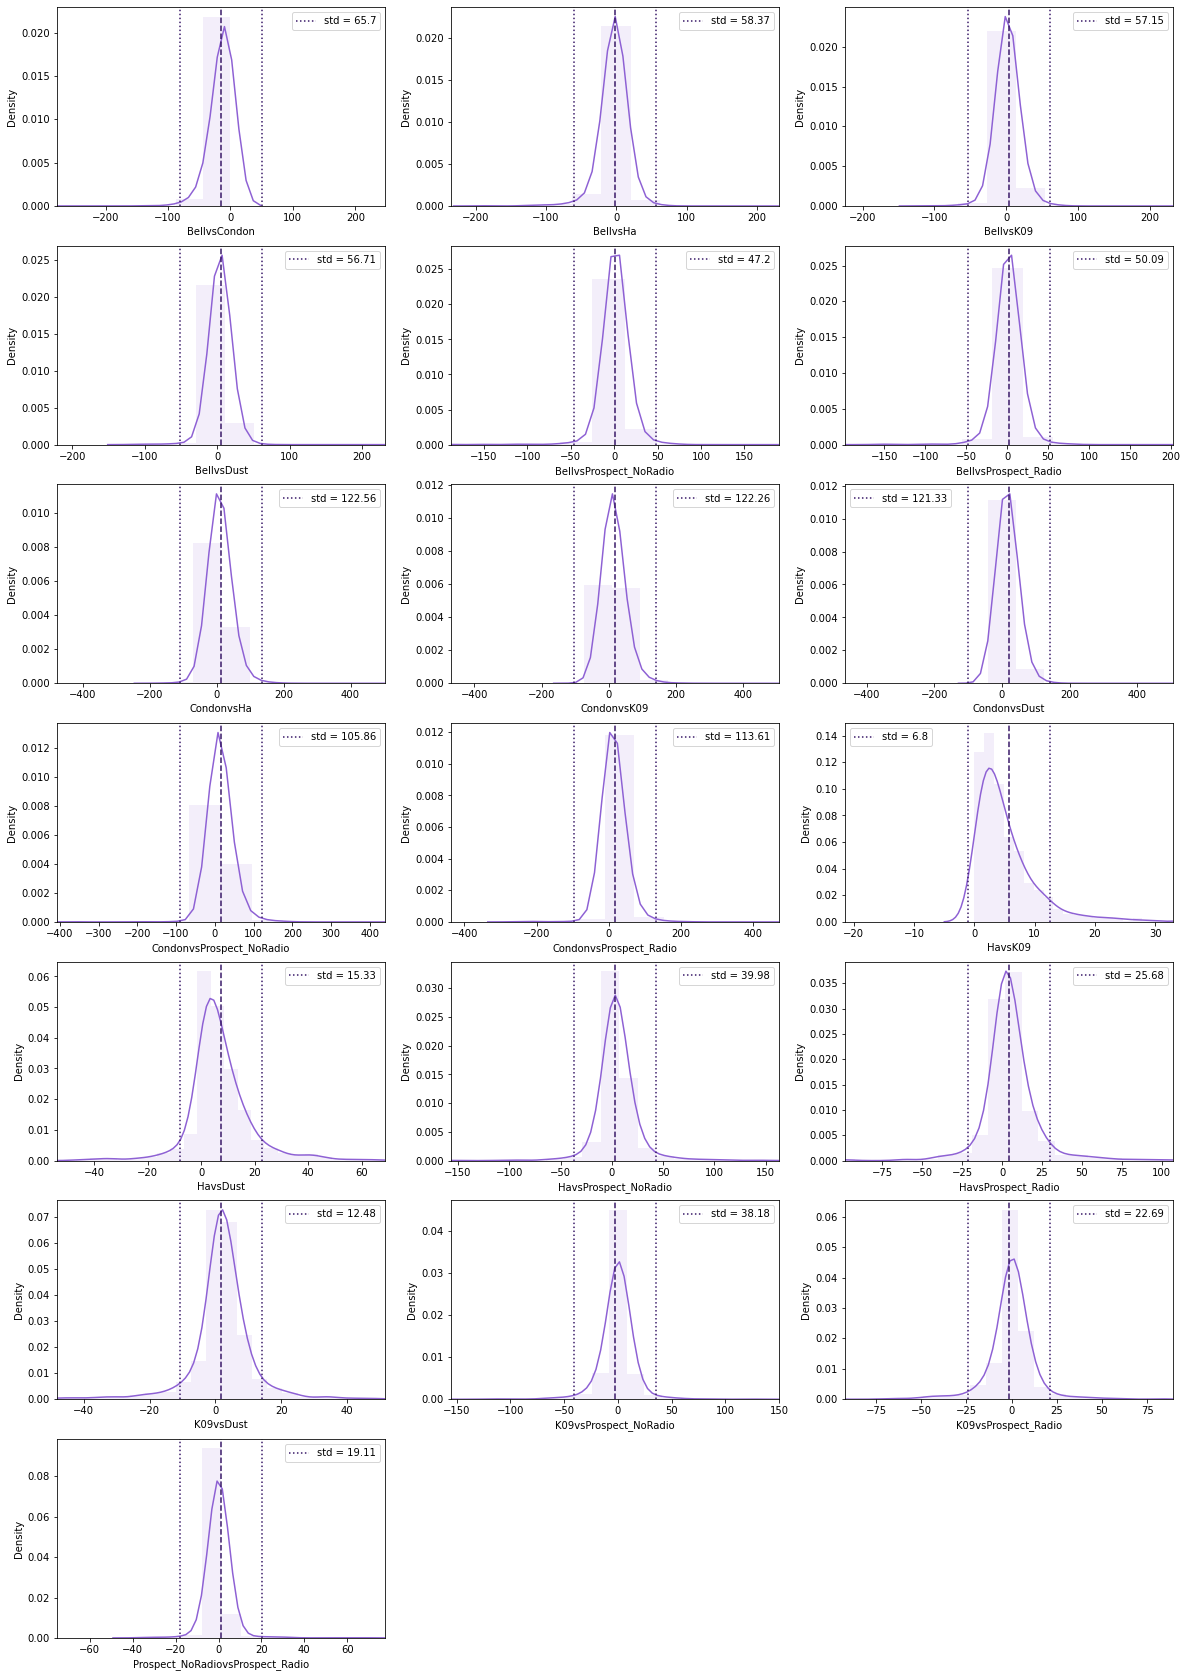

In [114]:

fig, axes = plt.subplots(7,3, figsize=(20, 30))
for name, ax in zip(dist_df.columns.values, axes.flatten()):
    sns.distplot(dist_df[name],
                 kde_kws={"color": "#8e61d4", "lw": 1.5},
                 hist_kws={"histtype": "stepfilled", "linewidth": 1, "alpha": 0.1, "color": "#8e61d4"},
                 norm_hist=True,  
                 ax=ax)
    #print(ax)
    ax.axvline(dist_df[name].mean()-dist_df[name].std(), linestyle=':', color='#361666', label=("std = {}".format(round(dist_df[name].std(),2))))
    ax.axvline(dist_df[name].mean()+dist_df[name].std(), linestyle=':', color='#361666')
    ax.axvline(dist_df[name].mean(), linestyle='--', color='#361666')
    ax.set_xlim(dist_df[name].mean()-4*dist_df[name].std(), dist_df[name].mean()+4*dist_df[name].std() )
    ax.legend()
    
fig.delaxes(axes[-1, -1])
fig.delaxes(axes[-1, -2])



In [115]:
std=[]
for name in dist_df.columns.values:
     std.append(["{}".format(name), round(dist_df[name].std(),2)])
     #print(name)
    
std

[['BellvsCondon', 65.7],
 ['BellvsHa', 58.37],
 ['BellvsK09', 57.15],
 ['BellvsDust', 56.71],
 ['BellvsProspect_NoRadio', 47.2],
 ['BellvsProspect_Radio', 50.09],
 ['CondonvsHa', 122.56],
 ['CondonvsK09', 122.26],
 ['CondonvsDust', 121.33],
 ['CondonvsProspect_NoRadio', 105.86],
 ['CondonvsProspect_Radio', 113.61],
 ['HavsK09', 6.8],
 ['HavsDust', 15.33],
 ['HavsProspect_NoRadio', 39.98],
 ['HavsProspect_Radio', 25.68],
 ['K09vsDust', 12.48],
 ['K09vsProspect_NoRadio', 38.18],
 ['K09vsProspect_Radio', 22.69],
 ['Prospect_NoRadiovsProspect_Radio', 19.11]]

### <span style='background :LightPink' > Fit Gaussians for sd!


In [116]:
def gaussian(x, a, mu, sigma):
        return a*np.exp(-(x-mu)**2/(2*sigma**2))

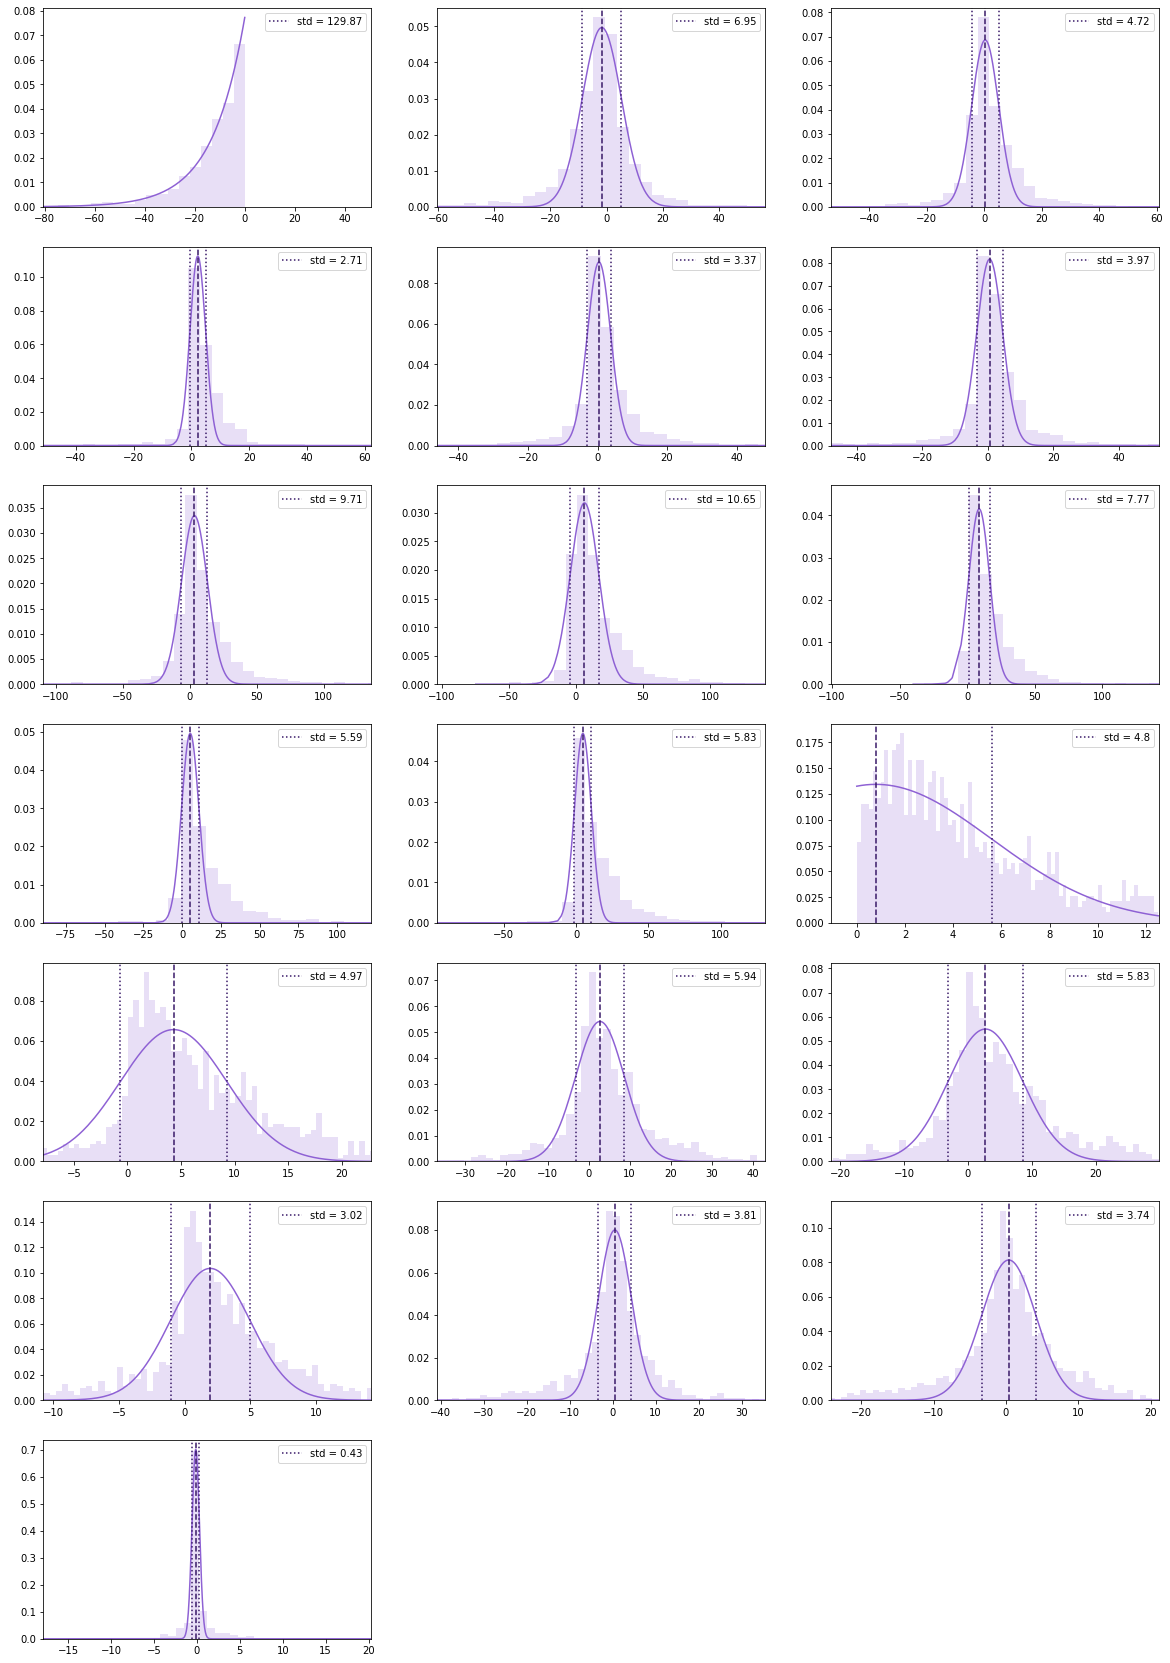

In [117]:
fig, axes = plt.subplots(7,3, figsize=(20, 30))
counts=[]
i=0
for name, ax in zip(dist_df.columns.values, axes.flatten()):
    
    bins=500
    
    try: 
        counts, bins, patches = ax.hist(dist_df[name].sort_values(), bins = bins, color = '#8e61d4', density = True, alpha=0.2)
    finally:
        
    
        bins= (bins[:-1] + np.diff(bins) / 2)

        #ax.axvline(dist_df[name].mean()-dist_df[name].std(), linestyle=':', color='#361666', label=("std = {}".format(round(dist_df[name].std(),2))))
        #ax.axvline(dist_df[name].mean()+dist_df[name].std(), linestyle=':', color='#361666')
        #ax.axvline(dist_df[name].mean(), linestyle='--', color='#361666')

        param, cov = curve_fit(gaussian, bins, counts, p0=(0,1,10), maxfev=100000)

        ax.plot(dist_df[name].sort_values(), gaussian(dist_df[name].sort_values(), *param), '-', color = '#8e61d4', lw=1.5)

        amp_gaus  = param[0] #amplitude 
        mean_gaus = param[1] #mean of gaussian dist
        std_gau   = param[2] #stdev of the dist

        #plt.legend(loc = 0, fontsize = 8)

        ax.set_xlim(dist_df[name].mean()-dist_df[name].std(), dist_df[name].mean()+dist_df[name].std() )
        
        ax.axvline(mean_gaus-std_gau, linestyle=':', color='#361666', label=("std = {}".format(round(std_gau,2))))
        ax.axvline(mean_gaus+std_gau, linestyle=':', color='#361666')
        ax.axvline(mean_gaus, linestyle='--', color='#361666')
        
        
        ax.legend()
    
fig.delaxes(axes[-1, -1])
fig.delaxes(axes[-1, -2])

### <span style='background :LightPink' > Scatter Diagram

D:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


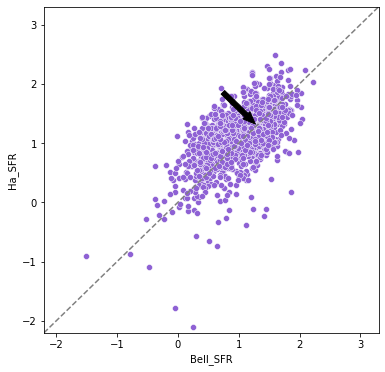

In [118]:
plt.figure( figsize=(6,6))
g=sns.scatterplot(np.log10(SFR_all['Bell_SFR']), np.log10(SFR_all['Ha_SFR']), color="#8e61d4")
g.set(xlim=(-2.2, 3.3), ylim=(-2.2,3.3))

scatx=np.arange(-2.2,3.4,0.1)
plt.plot(scatx, scatx, color='grey', alpha=1, linestyle='--')

#plt.plot((0.717505,1.298),(1.880142,1.298), marker='*')
#plt.arrow(0.717505,1.880142, 0.500495, -0.502142, head_width = 0.2, width = 0.07, color='black')
arr = mpatches.FancyArrowPatch((0.717505,1.880142),(1.298,1.298), arrowstyle='simple,head_width=.4', mutation_scale=25, color='black')
g.add_patch(arr)



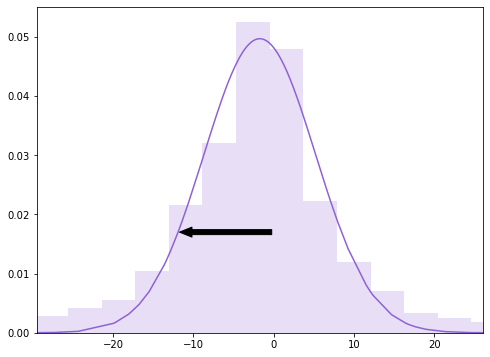

In [128]:
fig=plt.figure(figsize=(8, 6))

bins=500
     
counts, bins, patches = plt.hist(dist_df['BellvsHa'].sort_values(), bins = bins, color = '#8e61d4', density = True, alpha=0.2)
        
bins= (bins[:-1] + np.diff(bins) / 2)

param, cov = curve_fit(gaussian, bins, counts, p0=(0,1,10), maxfev=100000)

g=plt.plot(dist_df[name].sort_values(), gaussian(dist_df[name].sort_values(), *param), '-', color = '#8e61d4', lw=1.5)

amp_gaus  = param[0] #amplitude 
mean_gaus = param[1] #mean of gaussian dist
std_gau   = param[2] #stdev of the dist


plt.xlim(mean_gaus-4*std_gau, mean_gaus+4*std_gau )
        
arr = mpatches.FancyArrowPatch((0,0.017),(-11.99,0.017), arrowstyle='simple,head_width=.4', mutation_scale=25, color='black')
plt.gca().add_patch(arr)

        
        
ax.legend()
    


D:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


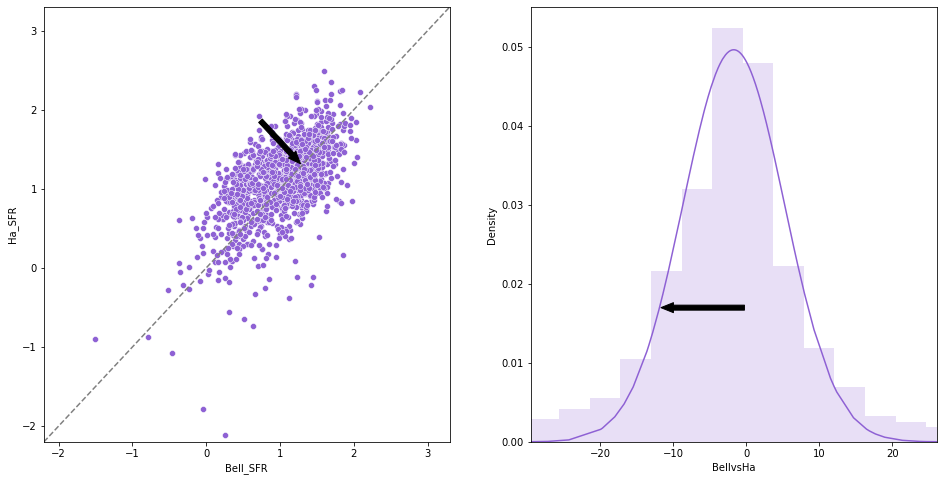

In [129]:
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(16, 8))
sns.scatterplot(np.log10(SFR_all['Bell_SFR']), np.log10(SFR_all['Ha_SFR']), color="#8e61d4", ax=ax1)
ax1.set(xlim=(-2.2, 3.3), ylim=(-2.2,3.3))
ax1.plot(scatx, scatx, color='grey', alpha=1, linestyle='--')
arr = mpatches.FancyArrowPatch((0.717505,1.880142),(1.298,1.298), arrowstyle='simple,head_width=.4', mutation_scale=25, color='black')
ax1.add_patch(arr)


bins=500
     
counts, bins, patches = ax2.hist(dist_df['BellvsHa'].sort_values(), bins = bins, color = '#8e61d4', density = True, alpha=0.2)
        
bins= (bins[:-1] + np.diff(bins) / 2)

param, cov = curve_fit(gaussian, bins, counts, p0=(0,1,10), maxfev=100000)

ax2.plot(dist_df[name].sort_values(), gaussian(dist_df[name].sort_values(), *param), '-', color = '#8e61d4', lw=1.5)

amp_gaus  = param[0] #amplitude 
mean_gaus = param[1] #mean of gaussian dist
std_gau   = param[2] #stdev of the dist

ax2.set_xlabel('BellvsHa')
ax2.set_ylabel('Density')
ax2.set_xlim(mean_gaus-4*std_gau, mean_gaus+4*std_gau )
        
arr1 = mpatches.FancyArrowPatch((0,0.017),(-11.99,0.017), arrowstyle='simple,head_width=.4', mutation_scale=25, color='black')
ax2.add_patch(arr1)

### <span style='background :LightPink' > Mean distances to 1to1
   


In [130]:
mean_dists=(['BellvsCondon',np.mean(dist_df['BellvsCondon'])],
        ['BellvsHa', np.mean(dist_df['BellvsHa'])],
        ['BellvsK09', np.mean(dist_df['BellvsK09'])],
        ['BellvsDust', np.mean(dist_df['BellvsDust'])],
        ['BellvsProspect_NoRadio', np.mean(dist_df['BellvsProspect_NoRadio'])],
        ['BellvsProspect_Radio', np.mean(dist_df['BellvsProspect_Radio'])],
            
        ['CondonvsHa', np.mean(dist_df['CondonvsHa'])],
        ['CondonvsK09',np.mean(dist_df['CondonvsK09'])],
        ['CondonvsDust', np.mean(dist_df['CondonvsDust'])],
        ['CondonvsProspect_NoRadio', np.mean(dist_df['CondonvsProspect_NoRadio'])],
        ['CondonvsProspect_Radio', np.mean(dist_df['CondonvsProspect_Radio'])],
            
        ['HavsK09', np.mean(dist_df['HavsK09'])],
        ['HavsDust', np.mean(dist_df['HavsDust'])],
        ['HavsProspect_NoRadio', np.mean(dist_df['HavsProspect_NoRadio'])],
        ['HavsProspect_Radio', np.mean(dist_df['HavsProspect_Radio'])],
            
        ['K09vsDust', np.mean(dist_df['K09vsDust'])],
        ['K09vsProspect_NoRadio', np.mean(dist_df['K09vsProspect_NoRadio'])],
        ['K09vsProspect_Radio', np.mean(dist_df['K09vsProspect_Radio'])],
            
        ['Prospect_NoRadiovsProspect_Radio', np.mean(dist_df['Prospect_NoRadiovsProspect_Radio'])]
           
           )

In [131]:
mean_dists

(['BellvsCondon', -15.061189878749664],
 ['BellvsHa', -2.0342769907987535],
 ['BellvsK09', 3.691128062009183],
 ['BellvsDust', 5.397250445748274],
 ['BellvsProspect_NoRadio', 0.9792377667221346],
 ['BellvsProspect_Radio', 2.1597347370539444],
 ['CondonvsHa', 13.026912887950921],
 ['CondonvsK09', 18.752317940758854],
 ['CondonvsDust', 20.45844032449794],
 ['CondonvsProspect_NoRadio', 16.04042764547179],
 ['CondonvsProspect_Radio', 17.22092461580359],
 ['HavsK09', 5.725405052807938],
 ['HavsDust', 7.4315274365470225],
 ['HavsProspect_NoRadio', 3.013514757520892],
 ['HavsProspect_Radio', 4.194011727852696],
 ['K09vsDust', 1.706122383739101],
 ['K09vsProspect_NoRadio', -2.7118902952870507],
 ['K09vsProspect_Radio', -1.5313933249552416],
 ['Prospect_NoRadiovsProspect_Radio', 1.1804969703318093])

### <span style='background :LightPink' > Correlation Coefficient

In [132]:
corrcoef=[]

corrcoef.append(['BellvsCondon',np.corrcoef(SFR_all['Bell_SFR'],SFR_all['Condon_SFR'])[0,1]])
corrcoef.append(['BellvsHa',np.corrcoef(SFR_all['Bell_SFR'],SFR_all['Ha_SFR'])[0,1]])
corrcoef.append(['BellvsK09',np.corrcoef(SFR_all['Bell_SFR'],SFR_all['K09_SFR'])[0,1]])
corrcoef.append(['BellvsDust',np.corrcoef(SFR_all['Bell_SFR'],SFR_all['Dust_SFR'])[0,1]])
corrcoef.append(['BellvsProspect_NoRadio',np.corrcoef(SFR_all['Bell_SFR'],SFR_all['Prospect_NoRadio_SFR'])[0,1]])
corrcoef.append(['BellvsProspect_Radio',np.corrcoef(SFR_all['Bell_SFR'],SFR_all['Prospect_Radio_SFR'])[0,1]])

corrcoef.append(['CondonvsHa',np.corrcoef(SFR_all['Condon_SFR'],SFR_all['Ha_SFR'])[0,1]])
corrcoef.append(['CondonvsK09',np.corrcoef(SFR_all['Condon_SFR'],SFR_all['K09_SFR'])[0,1]])
corrcoef.append(['CondonvsDust',np.corrcoef(SFR_all['Condon_SFR'],SFR_all['Dust_SFR'])[0,1]])
corrcoef.append(['CondonvsProspect_NoRadio',np.corrcoef(SFR_all['Condon_SFR'],SFR_all['Prospect_NoRadio_SFR'])[0,1]])
corrcoef.append(['CondonvsProspect_Radio',np.corrcoef(SFR_all['Condon_SFR'],SFR_all['Prospect_Radio_SFR'])[0,1]])

corrcoef.append(['HavsK09',np.corrcoef(SFR_all['Ha_SFR'],SFR_all['K09_SFR'])[0,1]])
corrcoef.append(['HavsDust',np.corrcoef(SFR_all['Ha_SFR'],SFR_all['Dust_SFR'])[0,1]])
corrcoef.append(['HavsProspect_NoRadio',np.corrcoef(SFR_all['Ha_SFR'],SFR_all['Prospect_NoRadio_SFR'])[0,1]])
corrcoef.append(['HavsProspect_Radio',np.corrcoef(SFR_all['Ha_SFR'],SFR_all['Prospect_Radio_SFR'])[0,1]])

corrcoef.append(['K09vsDust',np.corrcoef(SFR_all['K09_SFR'],SFR_all['Dust_SFR'])[0,1]])
corrcoef.append(['K09vsProspect_NoRadio',np.corrcoef(SFR_all['K09_SFR'],SFR_all['Prospect_NoRadio_SFR'])[0,1]])
corrcoef.append(['K09vsProspect_Radio',np.corrcoef(SFR_all['K09_SFR'],SFR_all['Prospect_Radio_SFR'])[0,1]])

corrcoef.append(['Prospect_NoRadiovsProspect_Radio',np.corrcoef(SFR_all['Prospect_NoRadio_SFR'],SFR_all['Prospect_Radio_SFR'])[0,1]])


In [133]:
corrcoef

[['BellvsCondon', 0.9999988894695646],
 ['BellvsHa', 0.07440377970622589],
 ['BellvsK09', 0.07440377994155914],
 ['BellvsDust', 0.1440036522419911],
 ['BellvsProspect_NoRadio', 0.5664696323219472],
 ['BellvsProspect_Radio', 0.4842839166618753],
 ['CondonvsHa', 0.074785300122441],
 ['CondonvsK09', 0.07478530035870051],
 ['CondonvsDust', 0.14429935383315043],
 ['CondonvsProspect_NoRadio', 0.5665673090171461],
 ['CondonvsProspect_Radio', 0.48448430675060306],
 ['HavsK09', 0.9999999999999993],
 ['HavsDust', 0.5826253403537442],
 ['HavsProspect_NoRadio', 0.11222006016483904],
 ['HavsProspect_Radio', 0.181792798322892],
 ['K09vsDust', 0.5826253401361521],
 ['K09vsProspect_NoRadio', 0.11222005995183448],
 ['K09vsProspect_Radio', 0.18179279868393067],
 ['Prospect_NoRadiovsProspect_Radio', 0.9320682429558188]]

## <span style='background :LightPink' > SUMMARY STATS FOR CORNER PLOT

In [134]:
print("\033[1mBellvsCondon Values\033[0m\n\n", 'Distance to line of best fit:\n',dist_LOBF['BellvsCondon'] , "\n\n Distance to the 1-to-1 line", dist_df['BellvsCondon'], '\n\n The mean distance to the 1-to-1 line is:', dist_df['BellvsCondon'].mean(), '\n\n The standard deviation of the distances to the 1-to-1 line is: ', dist_df['BellvsCondon'].std(),  '\n\n The correlation coefficient between them is:', corrcoef[1][1])

BellvsCondon Values

 Distance to line of best fit:
 0      -0.049427
2      -0.047692
3      -0.047467
4      -0.049324
10     -0.027082
          ...   
5714   -0.050875
5719   -0.049963
5720   -0.042459
5722   -0.049972
5723    0.308667
Length: 1161, dtype: float64 

 Distance to the 1-to-1 line 0      -13.383311
2      -24.658408
3      -26.117954
4      -14.050251
10      -2.787730
          ...    
5714    -3.975548
5719    -9.904278
5720   -58.653006
5722    -9.840588
5723    -0.549457
Name: BellvsCondon, Length: 1161, dtype: float64 

 The mean distance to the 1-to-1 line is: -15.061189878749664 

 The standard deviation of the distances to the 1-to-1 line is:  65.70262712998867 

 The correlation coefficient between them is: 0.07440377970622589


In [135]:
print("\033[1mBellvsHa Values\033[0m\n\n", 'Distance to line of best fit:\n',dist_LOBF['BellvsHa'] , "\n\n Distance to the 1-to-1 line", dist_df['BellvsHa'], '\n\n The mean distance to the 1-to-1 line is:', dist_df['BellvsHa'].mean(), '\n\n The standard deviation of the distances to the 1-to-1 line is: ', dist_df['BellvsHa'].std(),  '\n\n The correlation coefficient between them is:', corrcoef[1][1])

BellvsHa Values

 Distance to line of best fit:
 0       -4.677122
2      -12.770148
3      -21.673870
4       -9.920389
10       4.767261
          ...    
5714    -0.593948
5719     4.222741
5720    21.195212
5722     3.555676
5723    19.549354
Length: 1161, dtype: float64 

 Distance to the 1-to-1 line 0       -6.831042
2       -3.021159
3       -8.084609
4       -9.975662
10      -9.076466
          ...    
5714   -11.898107
5719    -3.477979
5720    49.748108
5722    -4.003651
5723    -0.036405
Name: BellvsHa, Length: 1161, dtype: float64 

 The mean distance to the 1-to-1 line is: -2.0342769907987535 

 The standard deviation of the distances to the 1-to-1 line is:  58.37158117461789 

 The correlation coefficient between them is: 0.07440377970622589


In [136]:
print("\033[1mBellvsK09 Values\033[0m\n\n", 'Distance to line of best fit:\n',dist_LOBF['BellvsK09'] , "\n\n Distance to the 1-to-1 line", dist_df['BellvsK09'], '\n\n The mean distance to the 1-to-1 line is:', dist_df['BellvsK09'].mean(), '\n\n The standard deviation of the distances to the 1-to-1 line is: ', dist_df['BellvsK09'].std(),  '\n\n The correlation coefficient between them is:', corrcoef[1][1])

BellvsK09 Values

 Distance to line of best fit:
 0       -2.909886
2       -7.944986
3      -13.484463
4       -6.171999
10       2.965965
          ...    
5714    -0.369526
5719     2.627191
5720    13.186663
5722     2.212174
5723    12.162688
Length: 1161, dtype: float64 

 Distance to the 1-to-1 line 0        0.131116
2        6.191375
3        3.519378
4       -1.606696
10      -4.720390
          ...    
5714    -6.099991
5719     1.078196
5720    50.142761
5722     0.730357
5723     0.355120
Name: BellvsK09, Length: 1161, dtype: float64 

 The mean distance to the 1-to-1 line is: 3.691128062009183 

 The standard deviation of the distances to the 1-to-1 line is:  57.15053220400602 

 The correlation coefficient between them is: 0.07440377970622589


In [137]:
print("\033[1mBellvsDust Values\033[0m\n\n", 'Distance to line of best fit:\n',dist_LOBF['BellvsDust'] , "\n\n Distance to the 1-to-1 line", dist_df['BellvsDust'], '\n\n The mean distance to the 1-to-1 line is:', dist_df['BellvsDust'].mean(), '\n\n The standard deviation of the distances to the 1-to-1 line is: ', dist_df['BellvsDust'].std(),  '\n\n The correlation coefficient between them is:', corrcoef[1][1])

BellvsDust Values

 Distance to line of best fit:
 0       -0.659569
2       -5.052746
3       10.159103
4        4.981939
10       7.369064
          ...    
5714     9.517230
5719     0.225925
5720    12.781486
5722     2.874348
5723     9.753618
Length: 1161, dtype: float64 

 Distance to the 1-to-1 line 0        3.464130
2        9.747166
3       21.727130
4        8.011713
10       0.353170
          ...    
5714     2.829124
5719     1.192819
5720    50.683276
5722     3.013845
5723     0.646310
Name: BellvsDust, Length: 1161, dtype: float64 

 The mean distance to the 1-to-1 line is: 5.397250445748274 

 The standard deviation of the distances to the 1-to-1 line is:  56.70685239340237 

 The correlation coefficient between them is: 0.07440377970622589


In [138]:
print("\033[1mBellvsProspect_NoRadio Values\033[0m\n\n", 'Distance to line of best fit:\n',dist_LOBF['BellvsProspect_NoRadio'] , "\n\n Distance to the 1-to-1 line", dist_df['BellvsProspect_NoRadio'], '\n\n The mean distance to the 1-to-1 line is:', dist_df['BellvsProspect_NoRadio'].mean(), '\n\n The standard deviation of the distances to the 1-to-1 line is: ', dist_df['BellvsProspect_NoRadio'].std(),  '\n\n The correlation coefficient between them is:', corrcoef[1][1])

BellvsProspect_NoRadio Values

 Distance to line of best fit:
 0        9.234762
2      -13.315032
3       14.872316
4       11.566001
10       7.169832
          ...    
5714    -2.163929
5719    -3.966976
5720    33.478112
5722     3.949546
5723     8.480734
Length: 1161, dtype: float64 

 Distance to the 1-to-1 line 0        7.005166
2       -3.940831
3       18.143086
4        9.126671
10      -0.256449
          ...    
5714    -6.688240
5719    -4.847976
5720    49.773902
5722     1.098550
5723    -0.170188
Name: BellvsProspect_NoRadio, Length: 1161, dtype: float64 

 The mean distance to the 1-to-1 line is: 0.9792377667221346 

 The standard deviation of the distances to the 1-to-1 line is:  47.204041762341284 

 The correlation coefficient between them is: 0.07440377970622589


In [139]:
print("\033[1mBellvsProspect_Radio Values\033[0m\n\n", 'Distance to line of best fit:\n',dist_LOBF['BellvsProspect_Radio'] , "\n\n Distance to the 1-to-1 line", dist_df['BellvsProspect_Radio'], '\n\n The mean distance to the 1-to-1 line is:', dist_df['BellvsProspect_Radio'].mean(), '\n\n The standard deviation of the distances to the 1-to-1 line is: ', dist_df['BellvsProspect_Radio'].std(),  '\n\n The correlation coefficient between them is:', corrcoef[1][1])

BellvsProspect_Radio Values

 Distance to line of best fit:
 0        8.788602
2      -17.803361
3       11.433610
4       10.757499
10       7.548994
          ...    
5714     1.143802
5719    -5.475985
5720    23.408818
5722     3.560262
5723    10.471005
Length: 1161, dtype: float64 

 Distance to the 1-to-1 line 0        7.240525
2       -3.940831
3       18.116895
4        9.126671
10      -1.089247
          ...    
5714    -4.887634
5719    -5.471150
5720    49.657211
5722     0.983448
5723    -0.167045
Name: BellvsProspect_Radio, Length: 1161, dtype: float64 

 The mean distance to the 1-to-1 line is: 2.1597347370539444 

 The standard deviation of the distances to the 1-to-1 line is:  50.08880409784761 

 The correlation coefficient between them is: 0.07440377970622589


In [140]:
print("\033[1mCondonvsHa Values\033[0m\n\n", 'Distance to line of best fit:\n',dist_LOBF['CondonvsHa'] , "\n\n Distance to the 1-to-1 line", dist_df['CondonvsHa'], '\n\n The mean distance to the 1-to-1 line is:', dist_df['CondonvsHa'].mean(), '\n\n The standard deviation of the distances to the 1-to-1 line is: ', dist_df['CondonvsHa'].std(),  '\n\n The correlation coefficient between them is:', corrcoef[1][1])

CondonvsHa Values

 Distance to line of best fit:
 0       -4.677107
2      -12.770267
3      -21.675710
4       -9.921415
10       4.767180
          ...    
5714    -0.594400
5719     4.224185
5720    21.207347
5722     3.556967
5723    19.543473
Length: 1161, dtype: float64 

 Distance to the 1-to-1 line 0         6.552269
2        21.637249
3        18.033344
4         4.074589
10       -6.288736
           ...    
5714     -7.922559
5719      6.426299
5720    108.401114
5722      5.836936
5723      0.513052
Name: CondonvsHa, Length: 1161, dtype: float64 

 The mean distance to the 1-to-1 line is: 13.026912887950921 

 The standard deviation of the distances to the 1-to-1 line is:  122.56014719173676 

 The correlation coefficient between them is: 0.07440377970622589


In [141]:
print("\033[1mCondonvsK09 Values\033[0m\n\n", 'Distance to line of best fit:\n',dist_LOBF['CondonvsK09'] , "\n\n Distance to the 1-to-1 line", dist_df['CondonvsK09'], '\n\n The mean distance to the 1-to-1 line is:', dist_df['CondonvsK09'].mean(), '\n\n The standard deviation of the distances to the 1-to-1 line is: ', dist_df['CondonvsK09'].std(),  '\n\n The correlation coefficient between them is:', corrcoef[1][1])

CondonvsK09 Values

 Distance to line of best fit:
 0       -2.909489
2       -7.944004
3      -13.483815
4       -6.171817
10       2.965521
          ...    
5714    -0.369759
5719     2.627740
5720    13.192460
5722     2.212683
5723    12.157413
Length: 1161, dtype: float64 

 Distance to the 1-to-1 line 0        13.514427
2        30.849783
3        29.637332
4        12.443555
10       -1.932659
           ...    
5714     -2.124443
5719     10.982474
5720    108.795766
5722     10.570944
5723      0.904577
Name: CondonvsK09, Length: 1161, dtype: float64 

 The mean distance to the 1-to-1 line is: 18.752317940758854 

 The standard deviation of the distances to the 1-to-1 line is:  122.25827174651364 

 The correlation coefficient between them is: 0.07440377970622589


In [142]:
print("\033[1mCondonvsDust Values\033[0m\n\n", 'Distance to line of best fit:\n',dist_LOBF['CondonvsDust'] , "\n\n Distance to the 1-to-1 line", dist_df['CondonvsDust'], '\n\n The mean distance to the 1-to-1 line is:', dist_df['CondonvsDust'].mean(), '\n\n The standard deviation of the distances to the 1-to-1 line is: ', dist_df['CondonvsDust'].std(),  '\n\n The correlation coefficient between them is:', corrcoef[1][1])

CondonvsDust Values

 Distance to line of best fit:
 0       -0.658032
2       -5.052703
3       10.167937
4        4.986748
10       7.373219
          ...    
5714     9.523721
5719     0.227656
5720    12.794720
5722     2.877581
5723     9.744832
Length: 1161, dtype: float64 

 Distance to the 1-to-1 line 0        16.847441
2        34.405575
3        47.845084
4        22.061964
10        3.140901
           ...    
5714      6.804672
5719     11.097097
5720    109.336282
5722     12.854433
5723      1.195767
Name: CondonvsDust, Length: 1161, dtype: float64 

 The mean distance to the 1-to-1 line is: 20.45844032449794 

 The standard deviation of the distances to the 1-to-1 line is:  121.33022273777048 

 The correlation coefficient between them is: 0.07440377970622589


In [143]:
print("\033[1mCondonvsProspect_NoRadio Values\033[0m\n\n", 'Distance to line of best fit:\n',dist_LOBF['CondonvsProspect_NoRadio'] , "\n\n Distance to the 1-to-1 line", dist_df['CondonvsProspect_NoRadio'], '\n\n The mean distance to the 1-to-1 line is:', dist_df['CondonvsProspect_NoRadio'].mean(), '\n\n The standard deviation of the distances to the 1-to-1 line is: ', dist_df['CondonvsProspect_NoRadio'].std(),  '\n\n The correlation coefficient between them is:', corrcoef[1][1])

CondonvsProspect_NoRadio Values

 Distance to line of best fit:
 0        9.739762
2      -13.994004
3       15.673546
4       12.193430
10       7.556446
          ...    
5714    -2.257640
5719    -4.155280
5720    35.256857
5722     4.176955
5723     8.798848
Length: 1161, dtype: float64 

 Distance to the 1-to-1 line 0        20.388477
2        20.717578
3        44.261040
4        23.176922
10        2.531282
           ...    
5714     -2.712692
5719      5.056302
5720    108.426908
5722     10.939137
5723      0.379270
Name: CondonvsProspect_NoRadio, Length: 1161, dtype: float64 

 The mean distance to the 1-to-1 line is: 16.04042764547179 

 The standard deviation of the distances to the 1-to-1 line is:  105.8606222067954 

 The correlation coefficient between them is: 0.07440377970622589


In [144]:
print("\033[1mCondonvsProspect_Radio Values\033[0m\n\n", 'Distance to line of best fit:\n',dist_LOBF['CondonvsProspect_Radio'] , "\n\n Distance to the 1-to-1 line", dist_df['CondonvsProspect_Radio'], '\n\n The mean distance to the 1-to-1 line is:', dist_df['CondonvsProspect_Radio'].mean(), '\n\n The standard deviation of the distances to the 1-to-1 line is: ', dist_df['CondonvsProspect_Radio'].std(),  '\n\n The correlation coefficient between them is:', corrcoef[1][1])

CondonvsProspect_Radio Values

 Distance to line of best fit:
 0        8.916468
2      -18.031576
3       11.597758
4       10.911824
10       7.654666
          ...    
5714     1.168513
5719    -5.539722
5720    23.735664
5722     3.617759
5723    10.547012
Length: 1161, dtype: float64 

 Distance to the 1-to-1 line 0        20.623836
2        20.717578
3        44.234849
4        23.176922
10        1.698484
           ...    
5714     -0.912086
5719      4.433128
5720    108.310217
5722     10.824036
5723      0.382412
Name: CondonvsProspect_Radio, Length: 1161, dtype: float64 

 The mean distance to the 1-to-1 line is: 17.22092461580359 

 The standard deviation of the distances to the 1-to-1 line is:  113.60914061411044 

 The correlation coefficient between them is: 0.07440377970622589


In [145]:
print("\033[1mHavsK09 Values\033[0m\n\n", 'Distance to line of best fit:\n',dist_LOBF['HavsK09'] , "\n\n Distance to the 1-to-1 line", dist_df['HavsK09'], '\n\n The mean distance to the 1-to-1 line is:', dist_df['HavsK09'].mean(), '\n\n The standard deviation of the distances to the 1-to-1 line is: ', dist_df['HavsK09'].std(),  '\n\n The correlation coefficient between them is:', corrcoef[1][1])

HavsK09 Values

 Distance to line of best fit:
 0      -1.671658e-07
2      -1.100475e-06
3      -4.030286e-07
4      -6.342296e-07
10     -5.160073e-07
            ...     
5714   -2.338657e-07
5719   -7.644015e-08
5720    5.670030e-09
5722   -2.513064e-07
5723    1.635273e-11
Length: 1161, dtype: float64 

 Distance to the 1-to-1 line 0        6.962159
2        9.212534
3       11.603987
4        8.368966
10       4.356077
          ...    
5714     5.798116
5719     4.556175
5720     0.394653
5722     4.734008
5723     0.391525
Name: HavsK09, Length: 1161, dtype: float64 

 The mean distance to the 1-to-1 line is: 5.725405052807938 

 The standard deviation of the distances to the 1-to-1 line is:  6.803407292106465 

 The correlation coefficient between them is: 0.07440377970622589


In [146]:
print("\033[1mHavsDust Values\033[0m\n\n", 'Distance to line of best fit:\n',dist_LOBF['HavsDust'] , "\n\n Distance to the 1-to-1 line", dist_df['HavsDust'], '\n\n The mean distance to the 1-to-1 line is:', dist_df['HavsDust'].mean(), '\n\n The standard deviation of the distances to the 1-to-1 line is: ', dist_df['HavsDust'].std(),  '\n\n The correlation coefficient between them is:', corrcoef[1][1])

HavsDust Values

 Distance to line of best fit:
 0        1.508237
2        0.772626
3       18.315965
4        8.861523
10       4.900726
          ...    
5714     9.149172
5719    -1.493818
5720     0.931638
5722     1.182800
5723     0.616104
Length: 1161, dtype: float64 

 Distance to the 1-to-1 line 0       10.295172
2       12.768325
3       29.811740
4       17.987376
10       9.429637
          ...    
5714    14.727231
5719     4.670797
5720     0.935168
5722     7.017496
5723     0.682715
Name: HavsDust, Length: 1161, dtype: float64 

 The mean distance to the 1-to-1 line is: 7.4315274365470225 

 The standard deviation of the distances to the 1-to-1 line is:  15.32775522307832 

 The correlation coefficient between them is: 0.07440377970622589


In [147]:
print("\033[1mHavsProspect_NoRadio Values\033[0m\n\n", 'Distance to line of best fit:\n',dist_LOBF['HavsProspect_NoRadio'] , "\n\n Distance to the 1-to-1 line", dist_df['HavsProspect_NoRadio'], '\n\n The mean distance to the 1-to-1 line is:', dist_df['HavsProspect_NoRadio'].mean(), '\n\n The standard deviation of the distances to the 1-to-1 line is: ', dist_df['HavsProspect_NoRadio'].std(),  '\n\n The correlation coefficient between them is:', corrcoef[1][1])

HavsProspect_NoRadio Values

 Distance to line of best fit:
 0       11.454476
2      -15.123355
3       15.587790
4       14.786600
10      11.805513
          ...    
5714     2.820933
5719    -2.778645
5720    10.729564
5722     5.635499
5723    10.518607
Length: 1161, dtype: float64 

 Distance to the 1-to-1 line 0       13.836209
2       -0.919672
3       26.227695
4       19.102334
10       8.820017
          ...    
5714     5.209867
5719    -1.369997
5720     0.025794
5722     5.102201
5723    -0.133783
Name: HavsProspect_NoRadio, Length: 1161, dtype: float64 

 The mean distance to the 1-to-1 line is: 3.013514757520892 

 The standard deviation of the distances to the 1-to-1 line is:  39.98449460075624 

 The correlation coefficient between them is: 0.07440377970622589


In [148]:
print("\033[1mHavsProspect_Radio Values\033[0m\n\n", 'Distance to line of best fit:\n',dist_LOBF['HavsProspect_Radio'] , "\n\n Distance to the 1-to-1 line", dist_df['HavsProspect_Radio'], '\n\n The mean distance to the 1-to-1 line is:', dist_df['HavsProspect_Radio'].mean(), '\n\n The standard deviation of the distances to the 1-to-1 line is: ', dist_df['HavsProspect_Radio'].std(),  '\n\n The correlation coefficient between them is:', corrcoef[1][1])

HavsProspect_Radio Values

 Distance to line of best fit:
 0       10.119706
2      -16.987349
3       13.657502
4       13.062390
10       9.135753
          ...    
5714     3.682315
5719    -5.215833
5720     9.256447
5722     3.917108
5723     9.210469
Length: 1161, dtype: float64 

 Distance to the 1-to-1 line 0       14.071567
2       -0.919672
3       26.201505
4       19.102333
10       7.987220
          ...    
5714     7.010474
5719    -1.993171
5720    -0.090897
5722     4.987100
5723    -0.130640
Name: HavsProspect_Radio, Length: 1161, dtype: float64 

 The mean distance to the 1-to-1 line is: 4.194011727852696 

 The standard deviation of the distances to the 1-to-1 line is:  25.679795469015296 

 The correlation coefficient between them is: 0.07440377970622589


In [149]:
print("\033[1mK09vsDust Values\033[0m\n\n", 'Distance to line of best fit:\n',dist_LOBF['K09vsDust'] , "\n\n Distance to the 1-to-1 line", dist_df['K09vsDust'], '\n\n The mean distance to the 1-to-1 line is:', dist_df['K09vsDust'].mean(), '\n\n The standard deviation of the distances to the 1-to-1 line is: ', dist_df['K09vsDust'].std(),  '\n\n The correlation coefficient between them is:', corrcoef[1][1])

K09vsDust Values

 Distance to line of best fit:
 0        1.320693
2        0.676552
3       16.038430
4        7.759618
10       4.291336
          ...    
5714     8.011500
5719    -1.308066
5720     0.815792
5722     1.035723
5723     0.539493
Length: 1161, dtype: float64 

 Distance to the 1-to-1 line 0        3.333013
2        3.555791
3       18.207752
4        9.618409
10       5.073560
          ...    
5714     8.929115
5719     0.114623
5720     0.540515
5722     2.283488
5723     0.291190
Name: K09vsDust, Length: 1161, dtype: float64 

 The mean distance to the 1-to-1 line is: 1.706122383739101 

 The standard deviation of the distances to the 1-to-1 line is:  12.477391625179177 

 The correlation coefficient between them is: 0.07440377970622589


In [150]:
print("\033[1mK09vsProspect_NoRadio Values\033[0m\n\n", 'Distance to line of best fit:\n',dist_LOBF['K09vsProspect_NoRadio'] , "\n\n Distance to the 1-to-1 line", dist_df['K09vsProspect_NoRadio'], '\n\n The mean distance to the 1-to-1 line is:', dist_df['K09vsProspect_NoRadio'].mean(), '\n\n The standard deviation of the distances to the 1-to-1 line is: ', dist_df['K09vsProspect_NoRadio'].std(),  '\n\n The correlation coefficient between them is:', corrcoef[1][1])

K09vsProspect_NoRadio Values

 Distance to line of best fit:
 0       11.005409
2      -14.530452
3       14.976679
4       14.206899
10      11.342684
          ...    
5714     2.710340
5719    -2.669710
5720    10.308917
5722     5.414562
5723    10.106231
Length: 1161, dtype: float64 

 Distance to the 1-to-1 line 0        6.874050
2      -10.132206
3       14.623708
4       10.733367
10       4.463941
          ...    
5714    -0.588249
5719    -5.926172
5720    -0.368859
5722     0.368193
5723    -0.525308
Name: K09vsProspect_NoRadio, Length: 1161, dtype: float64 

 The mean distance to the 1-to-1 line is: -2.7118902952870507 

 The standard deviation of the distances to the 1-to-1 line is:  38.18119352464581 

 The correlation coefficient between them is: 0.07440377970622589


In [151]:
print("\033[1mK09vsProspect_Radio Values\033[0m\n\n", 'Distance to line of best fit:\n',dist_LOBF['K09vsProspect_Radio'] , "\n\n Distance to the 1-to-1 line", dist_df['K09vsProspect_Radio'], '\n\n The mean distance to the 1-to-1 line is:', dist_df['K09vsProspect_Radio'].mean(), '\n\n The standard deviation of the distances to the 1-to-1 line is: ', dist_df['K09vsProspect_Radio'].std(),  '\n\n The correlation coefficient between them is:', corrcoef[1][1])

K09vsProspect_Radio Values

 Distance to line of best fit:
 0        9.766030
2      -16.393654
3       13.180183
4       12.605870
10       8.816466
          ...    
5714     3.553621
5719    -5.033543
5720     8.932941
5722     3.780208
5723     8.888570
Length: 1161, dtype: float64 

 Distance to the 1-to-1 line 0        7.109409
2      -10.132206
3       14.597518
4       10.733367
10       3.631143
          ...    
5714     1.212357
5719    -6.549346
5720    -0.485550
5722     0.253092
5723    -0.522165
Name: K09vsProspect_Radio, Length: 1161, dtype: float64 

 The mean distance to the 1-to-1 line is: -1.5313933249552416 

 The standard deviation of the distances to the 1-to-1 line is:  22.691892883467876 

 The correlation coefficient between them is: 0.07440377970622589


In [152]:
print("\033[1mProspect_NoRadiovsProspect_Radio Values\033[0m\n\n", 'Distance to line of best fit:\n',dist_LOBF['Prospect_NoRadiovsProspect_Radio'] , "\n\n Distance to the 1-to-1 line", dist_df['Prospect_NoRadiovsProspect_Radio'], '\n\n The mean distance to the 1-to-1 line is:', dist_df['Prospect_NoRadiovsProspect_Radio'].mean(), '\n\n The standard deviation of the distances to the 1-to-1 line is: ', dist_df['Prospect_NoRadiovsProspect_Radio'].std(),  '\n\n The correlation coefficient between them is:', corrcoef[1][1])

Prospect_NoRadiovsProspect_Radio Values

 Distance to line of best fit:
 0       3.148850
2      -9.007284
3       2.886348
4       3.740355
10      2.895888
          ...   
5714    1.919665
5719   -2.983605
5720    4.753480
5722    1.086620
5723    4.815946
Length: 1161, dtype: float64 

 Distance to the 1-to-1 line 0       2.353587e-01
2       0.000000e+00
3      -2.619028e-02
4      -2.717424e-07
10     -8.327977e-01
            ...     
5714    1.800606e+00
5719   -6.231743e-01
5720   -1.166912e-01
5722   -1.151014e-01
5723    3.142746e-03
Name: Prospect_NoRadiovsProspect_Radio, Length: 1161, dtype: float64 

 The mean distance to the 1-to-1 line is: 1.1804969703318093 

 The standard deviation of the distances to the 1-to-1 line is:  19.110599233045956 

 The correlation coefficient between them is: 0.07440377970622589
